# Watch Price Valuator

## Imports

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from lightgbm import log_evaluation

import optuna
import optuna.integration.lightgbm as lgb_tuner


%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (12, 6)
plt.rc('axes', titlesize=22) 
plt.rc('figure', titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

## Data

### Extract

In [2]:
sqlite_file_name = "../scraper/database.db"
sqlite_url = f"sqlite:///{sqlite_file_name}"

In [3]:
df_original = pd.read_sql_table('watch', sqlite_url)

In [4]:
df = df_original.copy()

### Transform

In [5]:
df.columns

Index(['id', 'product_url', 'brand', 'series', 'model_num', 'model_id',
       'price', 'year', 'box', 'papers', 'image_url', 'image_filename'],
      dtype='object')

In [6]:
df.drop(['id', 'model_num', 'model_id', 'product_url', 'image_url', 'image_filename'], axis=1, inplace=True)

In [7]:
df.dtypes

brand     object
series    object
price      int64
year       int64
box         bool
papers      bool
dtype: object

In [8]:
df = df.astype({
    'brand': 'category',
    'series': 'category',
    # 'model_num': 'category'
})

In [9]:
df.shape

(4299, 6)

In [10]:
df.head()

,brand,series,price,year,box,papers
0,Rolex,Datejust,10500,2014,True,True
1,Omega,Speedmaster MKII,3560,2018,True,True
2,Cartier,Tank Francaise,2450,2007,True,False
3,Tag Heuer,Carrera,3470,2019,True,True
4,Rolex,Submariner,12100,2020,True,True


In [11]:
X, y = df.drop('price', axis=1), df['price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

### Inspect

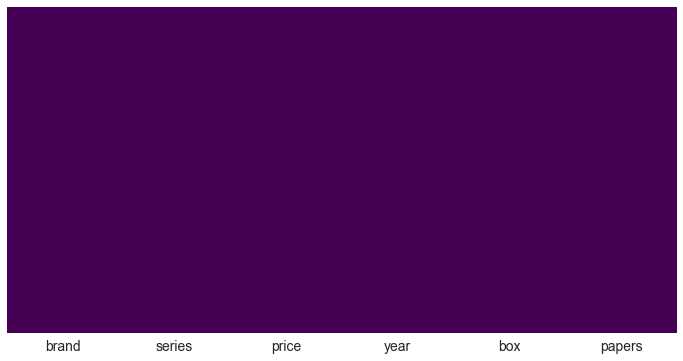

In [13]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

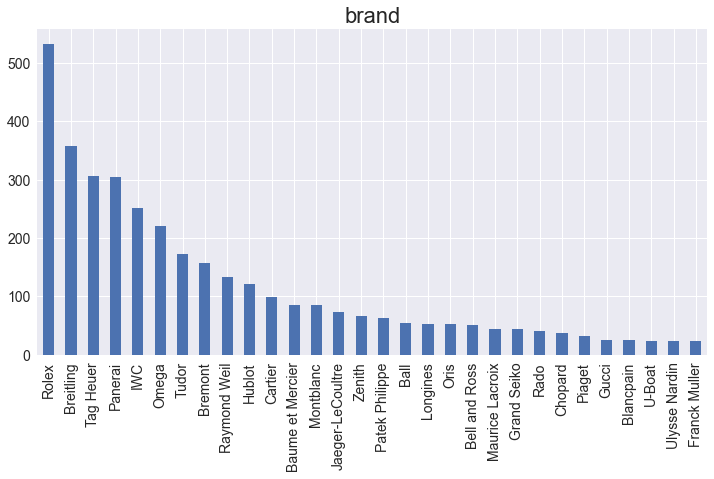

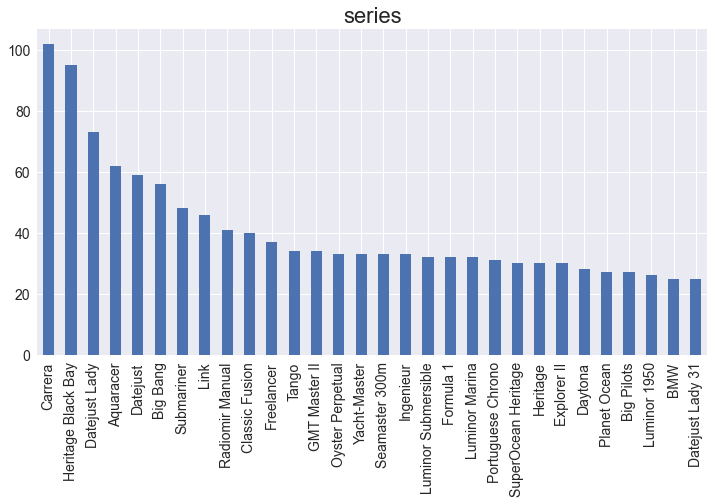

In [14]:
for col in ['brand', 'series']:#, 'model_num']:
    X_train[col].value_counts()[:30].plot(kind='bar')
    plt.title(col)
    plt.show()

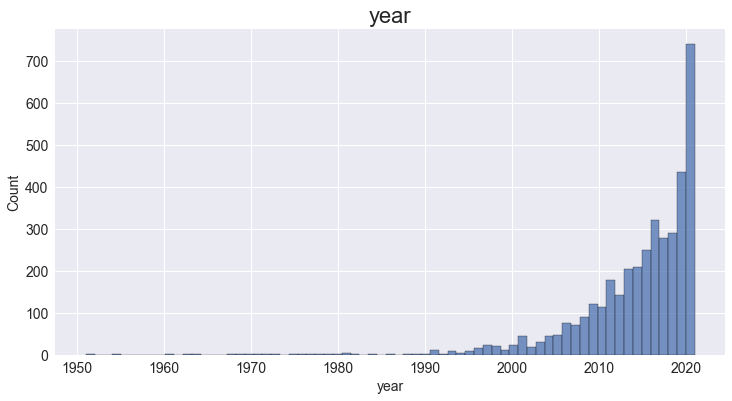

In [15]:
sns.histplot(data=X_train, x='year')
plt.title('year')
plt.show()

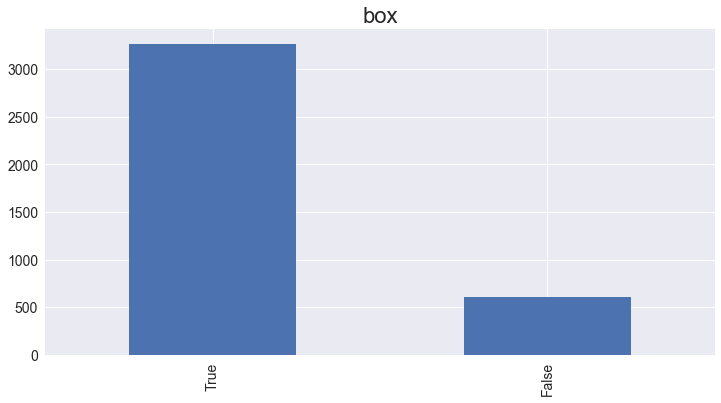

In [16]:
X_train['box'].value_counts().plot(kind='bar')
plt.title('box')
plt.show()

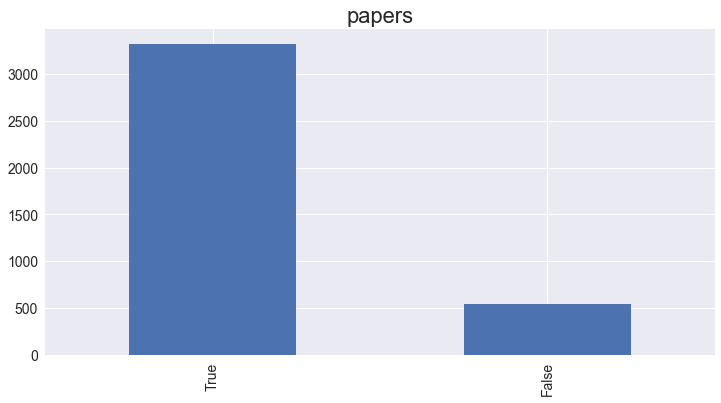

In [17]:
X_train['papers'].value_counts().plot(kind='bar')
plt.title('papers')
plt.show()

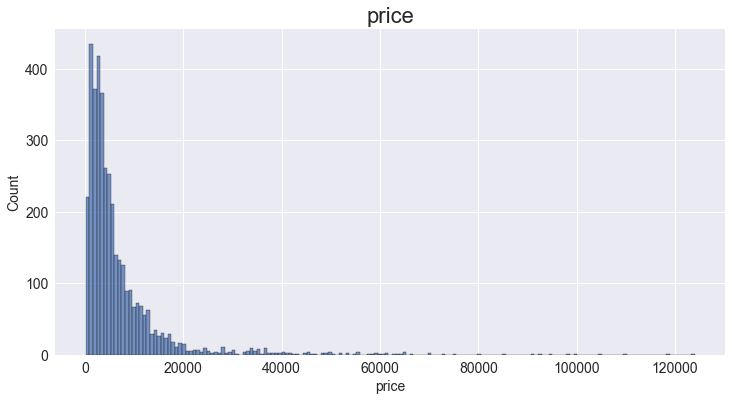

In [18]:
sns.histplot(y_train)
plt.title('price')
plt.show()

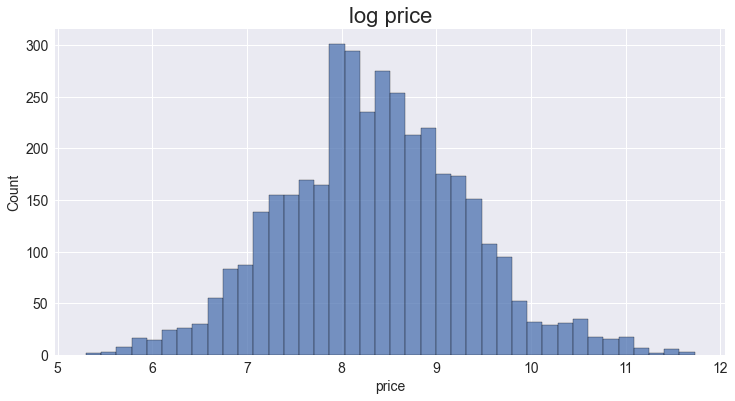

In [19]:
sns.histplot(np.log(y_train))
plt.title('log price')
plt.show()

### Feature Encoding

In [20]:
X_train_ = X_train.copy()
X_test_ = X_test.copy()

In [21]:
ohe_cols = ['brand', 'series']

In [22]:
ohe = OneHotEncoder()
ohe.fit(X[ohe_cols])

OneHotEncoder()

In [23]:
X_train_.reset_index(inplace=True)

In [24]:
X_train_ohe = pd.DataFrame(ohe.transform(X_train_[ohe_cols]).toarray(), columns=ohe.get_feature_names())

In [25]:
X_train_ = X_train_.drop(ohe_cols, axis=1).join(X_train_ohe)

In [26]:
X_train_['box'] = X_train_['box'].map({True: 1, False: 0})

In [27]:
X_train_['papers'] = X_train_['papers'].map({True: 1, False: 0})

In [28]:
X_test_.reset_index(inplace=True)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_[ohe_cols]).toarray(), columns=ohe.get_feature_names())
X_test_ = X_test_.drop(ohe_cols, axis=1).join(X_test_ohe)
X_test_['box'] = X_test_['box'].map({True: 1, False: 0})
X_test_['papers'] = X_test_['papers'].map({True: 1, False: 0})

In [29]:
-cross_val_score(LinearRegression(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

235321820451.261

In [30]:
-cross_val_score(Lasso(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6030.172811134574

In [31]:
-cross_val_score(Ridge(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5966.118547715936

In [32]:
-cross_val_score(DecisionTreeRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7621.477194205962

In [33]:
-cross_val_score(RandomForestRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6282.381561323017

In [34]:
-cross_val_score(XGBRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6317.11692093768

In [35]:
-cross_val_score(LGBMRegressor(), X_train_, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7448.201370574085

### Embeddings

In [36]:
X_train_ = X_train.copy()
X_test_ = X_test.copy()

In [37]:
X_train_['box'] = X_train_['box'].map({True: 1, False: 0})
X_train_['papers'] = X_train_['papers'].map({True: 1, False: 0})

In [38]:
def rm_spaces(feature):
    return re.sub(r'[^0-9a-zA-Z]', '', feature)

In [39]:
brand_tokenizer = Tokenizer(oov_token="<OOV>")
brand_tokenizer.fit_on_texts(X['brand'].apply(lambda x: rm_spaces(x)))
brand_tokenizer.word_index

{'<OOV>': 1,
 'rolex': 2,
 'breitling': 3,
 'tagheuer': 4,
 'panerai': 5,
 'iwc': 6,
 'omega': 7,
 'tudor': 8,
 'bremont': 9,
 'raymondweil': 10,
 'hublot': 11,
 'cartier': 12,
 'baumeetmercier': 13,
 'montblanc': 14,
 'jaegerlecoultre': 15,
 'zenith': 16,
 'patekphilippe': 17,
 'ball': 18,
 'bellandross': 19,
 'oris': 20,
 'longines': 21,
 'mauricelacroix': 22,
 'grandseiko': 23,
 'rado': 24,
 'chopard': 25,
 'piaget': 26,
 'gucci': 27,
 'blancpain': 28,
 'franckmuller': 29,
 'ulyssenardin': 30,
 'uboat': 31,
 'audemarspiguet': 32,
 'girardperregaux': 33,
 'bvlgari': 34,
 'vacheronconstantin': 35,
 'tissot': 36,
 'breguet': 37,
 'frederiqueconstant': 38,
 'glashutteoriginal': 39,
 'chanel': 40,
 'christiandior': 41,
 'porschedesign': 42,
 'hamilton': 43,
 'corum': 44,
 'ebel': 45,
 'nomosglashutte': 46,
 'rogerdubuis': 47,
 'eterna': 48,
 'graham': 49,
 'parmigiani': 50,
 'jeanrichard': 51,
 'alpina': 52,
 'twsteel': 53,
 'chronoswiss': 54,
 'alangeandsohne': 55,
 'hmoserandcie': 56,


In [40]:
series_tokenizer = Tokenizer(oov_token="<OOV>")
series_tokenizer.fit_on_texts(X['series'].apply(lambda x: rm_spaces(x)))
series_tokenizer.word_index

{'<OOV>': 1,
 'carrera': 2,
 'heritageblackbay': 3,
 'datejustlady': 4,
 'aquaracer': 5,
 'datejust': 6,
 'bigbang': 7,
 'submariner': 8,
 'link': 9,
 'radiomirmanual': 10,
 'classicfusion': 11,
 'oysterperpetual': 12,
 'freelancer': 13,
 'gmtmasterii': 14,
 'formula1': 15,
 'seamaster300m': 16,
 'yachtmaster': 17,
 'planetocean': 18,
 'tango': 19,
 'ingenieur': 20,
 'portuguesechrono': 21,
 'superoceanheritage': 22,
 'luminormarina': 23,
 'luminorsubmersible': 24,
 'heritage': 25,
 'explorerii': 26,
 'daytona': 27,
 'datejustlady31': 28,
 'bigpilots': 29,
 'luminor1950': 30,
 'bmw': 31,
 'skydweller': 32,
 'martinbaker': 33,
 'complications': 34,
 'clifton': 35,
 'timewalker': 36,
 'solo': 37,
 'boeing': 38,
 'alt1': 39,
 'speedmastermoonwatch': 40,
 'aerospace': 41,
 'supermarine': 42,
 'pilotschrono': 43,
 'deepsea': 44,
 'navitimerworld': 45,
 'explorer': 46,
 'datejustii': 47,
 'aquatimer': 48,
 'blackbay': 49,
 'classimaexecutives': 50,
 'heritagecollection': 51,
 'datejust41': 5

In [41]:
X_train.reset_index()

,index,brand,series,year,box,papers
0,3916,Tag Heuer,Carrera,2021,True,True
1,1041,IWC,Pilots Chrono Antoine de St Exupéry,2017,True,True
2,1322,Grand Seiko,Spring Drive,2016,True,True
3,2260,Tag Heuer,Carrera,2019,True,True
4,1769,Breitling,Avenger II Seawolf,2017,False,True
...,...,...,...,...,...,...
3864,3444,Piaget,Possession,2015,True,True
3865,466,Breitling,Aerospace,2010,True,True
3866,3092,Montblanc,Heritage,2021,True,True
3867,3772,Bell and Ross,BR V3-94,2019,True,True


In [42]:
brand_train_labels = brand_tokenizer.texts_to_sequences(X_train['brand'].apply(lambda x: rm_spaces(x)))
brand_test_labels = brand_tokenizer.texts_to_sequences(X_test['brand'].apply(lambda x: rm_spaces(x)))

series_train_labels = series_tokenizer.texts_to_sequences(X_train['series'].apply(lambda x: rm_spaces(x)))
series_test_labels = series_tokenizer.texts_to_sequences(X_test['series'].apply(lambda x: rm_spaces(x)))

In [43]:
brand_train_labels = tf.squeeze(tf.constant(brand_train_labels))
brand_test_labels = tf.squeeze(tf.constant(brand_test_labels))

series_train_labels = tf.squeeze(tf.constant(series_train_labels))
series_test_labels = tf.squeeze(tf.constant(series_test_labels))

In [44]:
num_brand = len(brand_tokenizer.word_index)
num_series = len(series_tokenizer.word_index)

In [45]:
num_brand

78

In [46]:
num_series

772

In [47]:
num_brand**0.25

2.9718278662008415

In [48]:
num_series**0.25

5.271137256693247

In [49]:
early_stopping_keras = EarlyStopping(patience=30, restore_best_weights=True)

In [50]:
brand_dim = 5
series_dim = 15


## Create the layers
# First input
input_brand = tf.keras.layers.Input(shape=(1,))
# Second input
input_series = tf.keras.layers.Input(shape=(1,))
# First embedding layer
embedding_brand = Embedding(input_dim=num_brand+1, output_dim=brand_dim,
                           name='embedding_brand')(input_brand)
# Second embedding layer
embedding_series = Embedding(input_dim=num_series+1, output_dim=series_dim,
                            name='embedding_series')(input_series)
# Concatenate the output of both embedding layers
concat = tf.keras.layers.Concatenate()([embedding_brand, embedding_series])

#
# concat = tf.keras.layers.Dense(12)(concat)

# A single neuron out with no activation function as this is a regression problem
output = tf.keras.layers.Dense(1)(concat)

# Create the model and feed it the layers to expect as inputs and outputs
model = tf.keras.Model(inputs=[input_brand, input_series],
                       outputs=output)
# Compile the model, with MSE as a loss function and Adam for the optimizer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(lr=3e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Fit the model!
history = model.fit((brand_train_labels, series_train_labels), y_train.to_numpy(),
                    validation_data=((brand_test_labels, series_test_labels),
                                     y_test.to_numpy()), epochs=3000, callbacks=[early_stopping_keras], verbose=2)
# List of performance histories
# histories.append(history)

Epoch 1/3000
121/121 - 2s - loss: 146006928.0000 - root_mean_squared_error: 12083.3330 - val_loss: 149353632.0000 - val_root_mean_squared_error: 12221.0322
Epoch 2/3000
121/121 - 0s - loss: 146004960.0000 - root_mean_squared_error: 12083.2510 - val_loss: 149351360.0000 - val_root_mean_squared_error: 12220.9395
Epoch 3/3000
121/121 - 0s - loss: 146002432.0000 - root_mean_squared_error: 12083.1465 - val_loss: 149348432.0000 - val_root_mean_squared_error: 12220.8193
Epoch 4/3000
121/121 - 0s - loss: 145999248.0000 - root_mean_squared_error: 12083.0146 - val_loss: 149344880.0000 - val_root_mean_squared_error: 12220.6738
Epoch 5/3000
121/121 - 0s - loss: 145995408.0000 - root_mean_squared_error: 12082.8555 - val_loss: 149340624.0000 - val_root_mean_squared_error: 12220.5000
Epoch 6/3000
121/121 - 0s - loss: 145990944.0000 - root_mean_squared_error: 12082.6709 - val_loss: 149335696.0000 - val_root_mean_squared_error: 12220.2988
Epoch 7/3000
121/121 - 0s - loss: 145985856.0000 - root_mean_squ

In [51]:
# Save the model after that hard work
model.save('trained_embedding_model.h5')

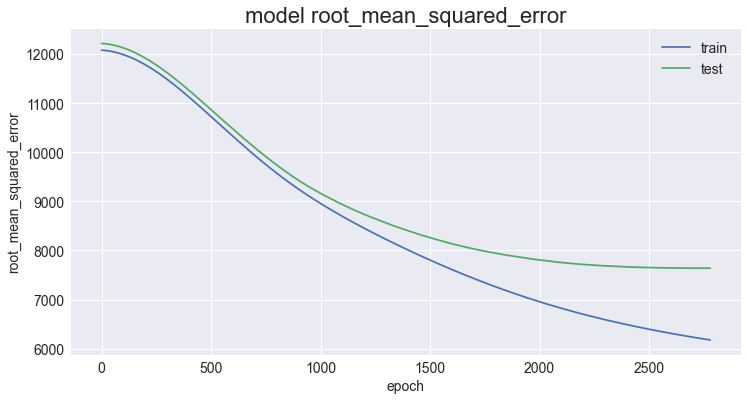

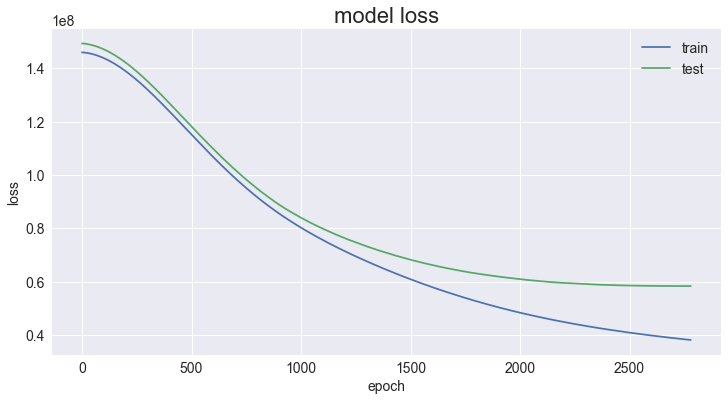

In [52]:
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [53]:
# Grab each embedding layer from the previous model
embedding_layer_brand = model.get_layer('embedding_brand')
# Ensure that the layer's parameters cannot be changed anymore!
embedding_layer_brand.trainable = False

embedding_layer_series = model.get_layer('embedding_series')
embedding_layer_series.trainable = False

In [54]:
# Create 2 new 'models', which recieve the sequences and matrix multiplies with
# the embedding layers to generate n and m features per sample,
# for brand and series respectively

# Sequential model
    feature_generator_brand = tf.keras.models.Sequential([
        # Input layer to establish the array shape to expect. This layer is also not trainable
        tf.keras.layers.InputLayer(input_shape=[1,]),
        # The learned embedding layer!
        embedding_layer_brand
    ])
    # Same for second model
    feature_generator_series = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=[1,]),
        embedding_layer_series
    ])

In [105]:
embedding_layer_brand.output_shape[2]

5

In [55]:
# Use the model's fit method to create the new features
brand_array = feature_generator_brand.predict(brand_train_labels)
print(brand_array.shape)
# Remove inner dimension, to go from 3D to 2D
brand_array = np.squeeze(brand_array, axis=1)
print(brand_array.shape)

(3869, 1, 5)
(3869, 5)


In [56]:
# Use the model's fit method to create the new features
series_array = feature_generator_series.predict(series_train_labels)
print(series_array.shape)
# Remove inner dimension, to go from 3D to 2D
series_array = np.squeeze(series_array, axis=1)
print(series_array.shape)

(3869, 1, 15)
(3869, 15)


In [57]:
features_array = np.concatenate((brand_array, series_array), axis=1)

In [58]:
embedding_cols = ["brand_embedding_" + str(i+1) for i in range(brand_dim)] + ["series_embedding_" + str(i+1) for i in range(series_dim)]

In [59]:
embedding_df = pd.DataFrame(features_array, columns=embedding_cols)

In [60]:
brand_train_labels = brand_tokenizer.texts_to_sequences(X['brand'].apply(lambda x: rm_spaces(x)))

In [61]:
def engineer_features(X: pd.DataFrame) -> pd.DataFrame:
    X_copy = X.copy()
    X_copy['box'] = X_copy['box'].map({True: 1, False: 0})
    X_copy['papers'] = X_copy['papers'].map({True: 1, False: 0})

    brand_labels = brand_tokenizer.texts_to_sequences(X['brand'].apply(lambda x: rm_spaces(x)))
    brand_labels = tf.squeeze(tf.constant(brand_labels))
    series_labels = series_tokenizer.texts_to_sequences(X['series'].apply(lambda x: rm_spaces(x)))
    series_labels = tf.squeeze(tf.constant(series_labels))

    brand_array = feature_generator_brand.predict(brand_labels)
    brand_array = np.squeeze(brand_array, axis=1)
    series_array = feature_generator_series.predict(series_labels)
    series_array = np.squeeze(series_array, axis=1)
    features_array = np.concatenate((brand_array, series_array), axis=1)

    embedding_cols = ["brand_embedding_" + str(i+1) for i in range(brand_dim)] + ["series_embedding_" + str(i+1) for i in range(series_dim)]
    embedding_df = pd.DataFrame(features_array, columns=embedding_cols)

    X_copy = X_copy.join(embedding_df)
    X_copy.drop(['brand', 'series'], axis=1, inplace=True)

    return X_copy

In [62]:
engineer_features(X)

,year,box,papers,brand_embedding_1,brand_embedding_2,brand_embedding_3,brand_embedding_4,brand_embedding_5,series_embedding_1,series_embedding_2,...,series_embedding_6,series_embedding_7,series_embedding_8,series_embedding_9,series_embedding_10,series_embedding_11,series_embedding_12,series_embedding_13,series_embedding_14,series_embedding_15
0,2014,1,1,34.705296,34.905579,-34.729343,-34.762165,34.848164,-1.337577,-1.391194,...,1.319361,1.342577,-1.352857,-1.312328,1.430974,1.337852,-1.317327,-1.238654,-1.415906,1.301923
1,2018,1,1,11.804050,11.946680,-11.791786,-11.808187,11.917798,-0.350696,-0.313275,...,0.299792,0.281983,-0.319706,-0.252436,0.372939,0.300081,-0.296842,-0.325173,-0.349496,0.257305
2,2007,1,0,16.360130,16.513355,-16.373014,-16.383837,16.482828,-2.388125,-2.430085,...,2.415656,2.411536,-2.370039,-2.337650,2.444479,2.396108,-2.336131,-2.327249,-2.441091,2.388119
3,2019,1,1,2.448477,2.580924,-2.424510,-2.440434,2.510045,2.195788,2.189751,...,-2.323830,-2.265299,2.242096,2.228628,-2.219402,-2.212262,2.221348,2.303640,2.225011,-2.306828
4,2020,1,1,34.705296,34.905579,-34.729343,-34.762165,34.848164,7.660012,7.658767,...,-7.706910,-7.685305,7.734345,7.704979,-7.679994,-7.734056,7.772711,7.733882,7.649186,-7.682530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4294,2016,1,1,20.982887,21.109499,-21.023256,-21.047258,21.153206,8.401306,8.368742,...,-8.432239,-8.320334,8.344626,8.365271,-8.303284,-8.376869,8.422767,8.383424,8.337200,-8.374763
4295,2019,1,1,20.982887,21.109499,-21.023256,-21.047258,21.153206,8.923313,8.898465,...,-8.955477,-8.903953,8.948065,8.955683,-8.978985,-8.912724,8.894409,8.910137,8.943853,-8.984735
4296,2010,1,1,20.982887,21.109499,-21.023256,-21.047258,21.153206,3.151215,3.105232,...,-3.106512,-3.144385,3.171759,3.169489,-3.078387,-3.153235,3.084434,3.146522,3.064838,-3.146273
4297,2015,1,1,2.448477,2.580924,-2.424510,-2.440434,2.510045,2.195788,2.189751,...,-2.323830,-2.265299,2.242096,2.228628,-2.219402,-2.212262,2.221348,2.303640,2.225011,-2.306828


In [63]:
X_train__, X_test__, y_train, y_test = train_test_split(
    engineer_features(X), y, test_size=0.10, random_state=42)

In [64]:
X_train__

,year,box,papers,brand_embedding_1,brand_embedding_2,brand_embedding_3,brand_embedding_4,brand_embedding_5,series_embedding_1,series_embedding_2,...,series_embedding_6,series_embedding_7,series_embedding_8,series_embedding_9,series_embedding_10,series_embedding_11,series_embedding_12,series_embedding_13,series_embedding_14,series_embedding_15
3916,2021,1,1,2.448477,2.580924,-2.424510,-2.440434,2.510045,2.195788,2.189751,...,-2.323830,-2.265299,2.242096,2.228628,-2.219402,-2.212262,2.221348,2.303640,2.225011,-2.306828
1041,2017,1,1,20.982887,21.109499,-21.023256,-21.047258,21.153206,-2.651138,-2.655221,...,2.601137,2.618162,-2.612986,-2.558593,2.639822,2.579579,-2.594711,-2.609276,-2.573787,2.577868
1322,2016,1,1,8.096763,8.164698,-8.121493,-8.102647,8.127980,4.424869,4.407893,...,-4.453604,-4.401007,4.466078,4.456071,-4.397704,-4.453181,4.430402,4.487143,4.410370,-4.434771
2260,2019,1,1,2.448477,2.580924,-2.424510,-2.440434,2.510045,2.195788,2.189751,...,-2.323830,-2.265299,2.242096,2.228628,-2.219402,-2.212262,2.221348,2.303640,2.225011,-2.306828
1769,2017,0,1,7.442590,7.596920,-7.500352,-7.519426,7.663404,0.023327,-0.045873,...,-0.049414,0.018126,-0.000746,0.049586,0.039403,0.040355,0.015450,0.058687,-0.017737,-0.020186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,2015,1,1,20.420231,20.484049,-20.443600,-20.447239,20.550945,-1.422358,-1.458162,...,1.374948,1.415845,-1.349456,-1.406399,1.473361,1.428006,-1.416226,-1.357580,-1.428285,1.401188
466,2010,1,1,7.442590,7.596920,-7.500352,-7.519426,7.663404,-0.391562,-0.425516,...,0.333191,0.358446,-0.420692,-0.344427,0.434669,0.412465,-0.406608,-0.343686,-0.397593,0.347113
3092,2021,1,1,8.466992,8.558669,-8.414504,-8.476301,8.517247,2.952441,2.927446,...,-2.997241,-2.879948,2.935854,2.910164,-2.917906,-2.885848,2.973851,2.915379,2.908981,-2.948717
3772,2019,1,1,8.845325,8.888520,-8.876746,-8.895202,8.904463,0.020004,-0.030002,...,-0.003731,-0.010470,0.020752,-0.012251,-0.015047,-0.035600,0.054789,0.073766,0.018619,-0.049178


In [65]:
-cross_val_score(LinearRegression(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5991.982227266333

In [66]:
-cross_val_score(Lasso(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51582816363.161934, tolerance: 29770057.36751535
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56911612377.65431, tolerance: 31357637.885231018
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44757220629.2112, tolerance: 27629856.123672053
  model = cd_fast.enet_coordinate_descent(
C:\Users\JustinGodden\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

6048.1180367890065

In [67]:
-cross_val_score(Ridge(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5987.196721845399

In [68]:
-cross_val_score(DecisionTreeRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

7013.0626874485315

In [69]:
-cross_val_score(RandomForestRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5893.836722560972

In [70]:
-cross_val_score(XGBRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

6238.170431204189

In [71]:
-cross_val_score(LGBMRegressor(), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

5796.925824001864

In [73]:
dtrain = lgb_tuner.Dataset(X_train__, label=y_train)

In [74]:
optuna.logging.set_verbosity(optuna.logging.FATAL)

In [87]:
optuna.logging.enable_propagation()

In [91]:
optuna.logging.enable_default_handler()

In [99]:
params = {
    "objective": "regression",
    "metric": "mean_squared_error",
    "verbosity": 0,
    "boosting_type": "gbdt",
}

In [100]:
tuner = lgb_tuner.LightGBMTunerCV(params,
                                  dtrain,
                                  num_boost_round=1000,
                                  folds=KFold(n_splits=5),
                                  callbacks=[early_stopping(100),
                                             log_evaluation(100)
                                             ],
                                  )

In [101]:
tuner.run()





  0%|          | 0/7 [00:00<?, ?it/s]



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.50774e+07 + 1.70133e+07
Training until validation scores don't improve for 100 rounds
[2]	cv_agg's l2: 7.57318e+07 + 1.60747e+07
[3]	cv_agg's l2: 6.82233e+0





feature_fraction, val_score: 33694515.123693:   0%|          | 0/7 [00:01<?, ?it/s]



feature_fraction, val_score: 33694515.123693:  14%|#4        | 1/7 [00:01<00:09,  1.55s/it]



feature_fraction, val_score: 33694515.123693:  14%|#4        | 1/7 [00:01<00:09,  1.55s/it]

[190]	cv_agg's l2: 3.45322e+07 + 1.02862e+07
[191]	cv_agg's l2: 3.45329e+07 + 1.02722e+07
Early stopping, best iteration is:
[91]	cv_agg's l2: 3.36945e+07 + 1.02733e+07
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	cv_agg's l2: 4.23022e+07 + 1.21836e+07
[11]	cv_agg's l2: 4.08101e+07 + 1.19016e+07
[12]	cv_agg's l2: 3.96359e+07 + 1.16354e+07
[13]	cv_agg's l2: 3.85504e+07 + 1.1378e+07
[14]	cv_agg's l2: 3.7786e+07 + 1.12933e+07
[15]	cv_agg's l2: 3.71822e+07 + 1.11037e+07
[16]	cv_agg's l2: 3.66969e+07 + 1.09856e+07
[17]	cv_agg's l2: 3.62457e+07 + 1.07838e+07
[18]	cv_agg's l2: 3.58678e+07 + 1.06849e+07
[19]	cv_agg's l2: 3.5514e+07 + 1.05435e+07
[20]	cv_agg's l2: 3.5205e+07 + 1.04667e+07
[21]	cv_agg's l2: 3.49821e+07 + 1.04e+07
[22]	cv_agg's l2: 3.48156e+07 + 1.034e+07
[23]	cv_agg's l2: 3.46227e+07 + 1.0128e+07
[24]	cv_agg's l2: 3.45373e+07 + 1.00406e+07
[25]	cv_agg's l2: 3.44484e+07 + 9.96139e+06
[26]	cv_agg's l2: 3.4279e+07 + 9.919e+06
[27]	cv_agg's l2: 3.41539e+07 + 9.85892e+06
[28]	cv_agg's l2: 3.41704e+07 + 9.84314e+06
[29]	cv_agg's l2: 3.40719e+07 + 9.88131e+06
[30]	cv_agg's l2: 3.41376e+07 + 9.852e+06
[31]	cv_agg's l2: 3.41332e+07 + 9.85188e+06
[32]	cv_agg's l2: 3.40674e+07 + 9.8809e+06
[33]





feature_fraction, val_score: 33192615.026655:  14%|#4        | 1/7 [00:03<00:09,  1.55s/it]



feature_fraction, val_score: 33192615.026655:  29%|##8       | 2/7 [00:03<00:08,  1.76s/it]



feature_fraction, val_score: 33192615.026655:  29%|##8       | 2/7 [00:03<00:08,  1.76s/it]

[207]	cv_agg's l2: 3.38319e+07 + 9.83013e+06
[208]	cv_agg's l2: 3.38341e+07 + 9.80288e+06
[209]	cv_agg's l2: 3.38516e+07 + 9.79188e+06
[210]	cv_agg's l2: 3.38721e+07 + 9.75609e+06
[211]	cv_agg's l2: 3.38561e+07 + 9.75371e+06
[212]	cv_agg's l2: 3.38483e+07 + 9.74665e+06
[213]	cv_agg's l2: 3.38464e+07 + 9.7619e+06
[214]	cv_agg's l2: 3.38627e+07 + 9.73752e+06
[215]	cv_agg's l2: 3.38624e+07 + 9.76124e+06
[216]	cv_agg's l2: 3.38846e+07 + 9.79878e+06
[217]	cv_agg's l2: 3.38723e+07 + 9.77964e+06
[218]	cv_agg's l2: 3.38829e+07 + 9.76477e+06
[219]	cv_agg's l2: 3.39014e+07 + 9.74524e+06
[220]	cv_agg's l2: 3.3942e+07 + 9.70591e+06
Early stopping, best iteration is:
[120]	cv_agg's l2: 3.31926e+07 + 9.67097e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_c

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	cv_agg's l2: 6.18586e+07 + 1.43563e+07
[5]	cv_agg's l2: 5.67786e+07 + 1.381e+07
[6]	cv_agg's l2: 5.26278e+07 + 1.33582e+07
[7]	cv_agg's l2: 4.92973e+07 + 1.30795e+07
[8]	cv_agg's l2: 4.65375e+07 + 1.27475e+07
[9]	cv_agg's l2: 4.43152e+07 + 1.24876e+07
[10]	cv_agg's l2: 4.24675e+07 + 1.21183e+07
[11]	cv_agg's l2: 4.09045e+07 + 1.18071e+07
[12]	cv_agg's l2: 3.97072e+07 + 1.16166e+07
[13]	cv_agg's l2: 3.85287e+07 + 1.12889e+07
[14]	cv_agg's l2: 3.77149e+07 + 1.10576e+07
[15]	cv_agg's l2: 3.70342e+07 + 1.08835e+07
[16]	cv_agg's l2: 3.65221e+07 + 1.08055e+07
[17]	cv_agg's l2: 3.60471e+07 + 1.06522e+07
[18]	cv_agg's l2: 3.57177e+07 + 1.05361e+07
[19]	cv_agg's l2: 3.53619e+07 + 1.03379e+07
[20]	cv_agg's l2: 3.50391e+07 + 1.0275e+07
[21]	cv_agg's l2: 3.48139e+07 + 1.01922e+07
[22]	cv_agg's l2: 3.46453e+07 + 1.0121e+07
[23]	cv_agg's l2: 3.4538e+07 + 1.00678e+07
[24]	cv_agg's l2: 3.44147e+07 + 9.99698e+06
[25]	cv_agg's l2: 3.42348e+07 + 9.86717e+06
[26]	cv_agg's l2: 3.40883e+07 + 9.86198e+06





feature_fraction, val_score: 32867659.252773:  29%|##8       | 2/7 [00:05<00:08,  1.76s/it]



feature_fraction, val_score: 32867659.252773:  43%|####2     | 3/7 [00:05<00:06,  1.70s/it]



feature_fraction, val_score: 32867659.252773:  43%|####2     | 3/7 [00:05<00:06,  1.70s/it]

[157]	cv_agg's l2: 3.31293e+07 + 9.66576e+06
[158]	cv_agg's l2: 3.31133e+07 + 9.65551e+06
[159]	cv_agg's l2: 3.31431e+07 + 9.67691e+06
[160]	cv_agg's l2: 3.31439e+07 + 9.66225e+06
[161]	cv_agg's l2: 3.31566e+07 + 9.67929e+06
[162]	cv_agg's l2: 3.31359e+07 + 9.67813e+06
[163]	cv_agg's l2: 3.31366e+07 + 9.64262e+06
[164]	cv_agg's l2: 3.31468e+07 + 9.65046e+06
[165]	cv_agg's l2: 3.31552e+07 + 9.68753e+06
[166]	cv_agg's l2: 3.31481e+07 + 9.6585e+06
[167]	cv_agg's l2: 3.31388e+07 + 9.64697e+06
[168]	cv_agg's l2: 3.31366e+07 + 9.63262e+06
[169]	cv_agg's l2: 3.3111e+07 + 9.62597e+06
[170]	cv_agg's l2: 3.31255e+07 + 9.6099e+06
[171]	cv_agg's l2: 3.3164e+07 + 9.62401e+06
[172]	cv_agg's l2: 3.31616e+07 + 9.64549e+06
[173]	cv_agg's l2: 3.31686e+07 + 9.65776e+06
[174]	cv_agg's l2: 3.31535e+07 + 9.64297e+06
[175]	cv_agg's l2: 3.31873e+07 + 9.65021e+06
[176]	cv_agg's l2: 3.31558e+07 + 9.64417e+06
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06


C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.50771e+07 + 1.70133e+07
[2]	cv_agg's l2: 7.57371e+07 + 1.60737e+07
[3]	cv_agg's l2: 6.82746e+07 + 1.5337e+07
[4]	cv_agg's l2: 6.19219e+07 + 1.47216e+07
[5]	





feature_fraction, val_score: 32867659.252773:  43%|####2     | 3/7 [00:07<00:06,  1.70s/it]



feature_fraction, val_score: 32867659.252773:  57%|#####7    | 4/7 [00:07<00:05,  1.83s/it]



feature_fraction, val_score: 32867659.252773:  57%|#####7    | 4/7 [00:07<00:05,  1.83s/it]

[172]	cv_agg's l2: 3.45046e+07 + 1.0245e+07
[173]	cv_agg's l2: 3.44888e+07 + 1.02686e+07
[174]	cv_agg's l2: 3.45034e+07 + 1.0271e+07
[175]	cv_agg's l2: 3.45429e+07 + 1.02545e+07
[176]	cv_agg's l2: 3.45619e+07 + 1.02375e+07
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	cv_agg's l2: 4.2562e+07 + 1.22112e+07
[11]	cv_agg's l2: 4.11875e+07 + 1.19489e+07
[12]	cv_agg's l2: 4.00119e+07 + 1.16801e+07
[13]	cv_agg's l2: 3.90542e+07 + 1.1486e+07
[14]	cv_agg's l2: 3.82758e+07 + 1.13345e+07
[15]	cv_agg's l2: 3.76736e+07 + 1.11794e+07
[16]	cv_agg's l2: 3.70302e+07 + 1.10426e+07
[17]	cv_agg's l2: 3.65648e+07 + 1.09598e+07
[18]	cv_agg's l2: 3.61418e+07 + 1.08709e+07
[19]	cv_agg's l2: 3.57502e+07 + 1.07899e+07
[20]	cv_agg's l2: 3.54591e+07 + 1.0718e+07
[21]	cv_agg's l2: 3.51397e+07 + 1.06294e+07
[22]	cv_agg's l2: 3.49856e+07 + 1.05171e+07
[23]	cv_agg's l2: 3.48862e+07 + 1.03893e+07
[24]	cv_agg's l2: 3.48159e+07 + 1.03653e+07
[25]	cv_agg's l2: 3.48049e+07 + 1.02741e+07
[26]	cv_agg's l2: 3.4659e+07 + 1.03334e+07
[27]	cv_agg's l2: 3.45883e+07 + 1.03474e+07
[28]	cv_agg's l2: 3.45255e+07 + 1.03737e+07
[29]	cv_agg's l2: 3.45022e+07 + 1.0289e+07
[30]	cv_agg's l2: 3.44772e+07 + 1.03358e+07
[31]	cv_agg's l2: 3.44711e+07 + 1.04173e+07
[32]	cv_agg's l2: 3.44175e+07 + 1.032





feature_fraction, val_score: 32867659.252773:  57%|#####7    | 4/7 [00:09<00:05,  1.83s/it]



feature_fraction, val_score: 32867659.252773:  71%|#######1  | 5/7 [00:09<00:03,  1.91s/it]



feature_fraction, val_score: 32867659.252773:  71%|#######1  | 5/7 [00:09<00:03,  1.91s/it]

[168]	cv_agg's l2: 3.44042e+07 + 1.01198e+07
[169]	cv_agg's l2: 3.44645e+07 + 1.01065e+07
[170]	cv_agg's l2: 3.44659e+07 + 1.00927e+07
[171]	cv_agg's l2: 3.44823e+07 + 1.00763e+07
[172]	cv_agg's l2: 3.4502e+07 + 1.00663e+07
[173]	cv_agg's l2: 3.44903e+07 + 1.00569e+07
[174]	cv_agg's l2: 3.45234e+07 + 1.00667e+07
[175]	cv_agg's l2: 3.45307e+07 + 1.00739e+07
[176]	cv_agg's l2: 3.45441e+07 + 1.00537e+07
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] A

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[8]	cv_agg's l2: 4.63683e+07 + 1.27891e+07
[9]	cv_agg's l2: 4.41002e+07 + 1.24088e+07
[10]	cv_agg's l2: 4.23702e+07 + 1.20501e+07
[11]	cv_agg's l2: 4.09327e+07 + 1.19204e+07
[12]	cv_agg's l2: 3.9688e+07 + 1.16649e+07
[13]	cv_agg's l2: 3.87448e+07 + 1.15015e+07
[14]	cv_agg's l2: 3.78797e+07 + 1.12635e+07
[15]	cv_agg's l2: 3.72502e+07 + 1.10338e+07
[16]	cv_agg's l2: 3.67213e+07 + 1.09391e+07
[17]	cv_agg's l2: 3.63117e+07 + 1.07914e+07
[18]	cv_agg's l2: 3.59364e+07 + 1.06679e+07
[19]	cv_agg's l2: 3.5533e+07 + 1.05678e+07
[20]	cv_agg's l2: 3.5298e+07 + 1.05123e+07
[21]	cv_agg's l2: 3.51049e+07 + 1.04355e+07
[22]	cv_agg's l2: 3.50792e+07 + 1.03944e+07
[23]	cv_agg's l2: 3.5022e+07 + 1.03137e+07
[24]	cv_agg's l2: 3.49817e+07 + 1.02576e+07
[25]	cv_agg's l2: 3.48976e+07 + 1.02086e+07
[26]	cv_agg's l2: 3.47463e+07 + 1.01949e+07
[27]	cv_agg's l2: 3.46445e+07 + 1.0215e+07
[28]	cv_agg's l2: 3.46165e+07 + 1.01919e+07
[29]	cv_agg's l2: 3.45306e+07 + 1.02067e+07
[30]	cv_agg's l2: 3.44277e+07 + 1.0188





feature_fraction, val_score: 32867659.252773:  71%|#######1  | 5/7 [00:10<00:03,  1.91s/it]



feature_fraction, val_score: 32867659.252773:  86%|########5 | 6/7 [00:10<00:01,  1.80s/it]



feature_fraction, val_score: 32867659.252773:  86%|########5 | 6/7 [00:10<00:01,  1.80s/it]

[159]	cv_agg's l2: 3.36595e+07 + 1.0117e+07
[160]	cv_agg's l2: 3.36493e+07 + 1.0132e+07
[161]	cv_agg's l2: 3.36647e+07 + 1.01256e+07
[162]	cv_agg's l2: 3.36881e+07 + 1.01198e+07
[163]	cv_agg's l2: 3.37035e+07 + 1.01244e+07
[164]	cv_agg's l2: 3.37108e+07 + 1.01189e+07
[165]	cv_agg's l2: 3.37106e+07 + 1.01024e+07
[166]	cv_agg's l2: 3.36986e+07 + 1.01115e+07
[167]	cv_agg's l2: 3.36892e+07 + 1.01275e+07
[168]	cv_agg's l2: 3.37041e+07 + 1.01641e+07
[169]	cv_agg's l2: 3.36857e+07 + 1.01765e+07
[170]	cv_agg's l2: 3.37015e+07 + 1.01961e+07
[171]	cv_agg's l2: 3.37165e+07 + 1.01884e+07
[172]	cv_agg's l2: 3.37261e+07 + 1.02131e+07
[173]	cv_agg's l2: 3.37583e+07 + 1.0246e+07
[174]	cv_agg's l2: 3.37809e+07 + 1.02359e+07
[175]	cv_agg's l2: 3.37669e+07 + 1.02232e+07
[176]	cv_agg's l2: 3.37726e+07 + 1.02387e+07
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	cv_agg's l2: 7.57389e+07 + 1.60732e+07
[3]	cv_agg's l2: 6.82744e+07 + 1.5337e+07
[4]	cv_agg's l2: 6.19195e+07 + 1.47221e+07
[5]	cv_agg's l2: 5.7011e+07 + 1.41627e+07
[6]	cv_agg's l2: 5.28604e+07 + 1.36075e+07
[7]	cv_agg's l2: 4.93911e+07 + 1.30178e+07
[8]	cv_agg's l2: 4.68507e+07 + 1.26062e+07
[9]	cv_agg's l2: 4.45168e+07 + 1.22106e+07
[10]	cv_agg's l2: 4.26266e+07 + 1.1853e+07
[11]	cv_agg's l2: 4.11448e+07 + 1.15549e+07
[12]	cv_agg's l2: 3.9878e+07 + 1.14473e+07
[13]	cv_agg's l2: 3.89491e+07 + 1.13109e+07
[14]	cv_agg's l2: 3.81595e+07 + 1.11336e+07
[15]	cv_agg's l2: 3.74978e+07 + 1.10052e+07
[16]	cv_agg's l2: 3.68584e+07 + 1.08288e+07
[17]	cv_agg's l2: 3.64109e+07 + 1.07725e+07
[18]	cv_agg's l2: 3.60147e+07 + 1.05983e+07
[19]	cv_agg's l2: 3.57703e+07 + 1.05857e+07
[20]	cv_agg's l2: 3.54702e+07 + 1.05133e+07
[21]	cv_agg's l2: 3.52418e+07 + 1.04233e+07
[22]	cv_agg's l2: 3.50435e+07 + 1.03727e+07
[23]	cv_agg's l2: 3.48793e+07 + 1.03364e+07
[24]	cv_agg's l2: 3.46784e+07 + 1.02262e+07






feature_fraction, val_score: 32867659.252773:  86%|########5 | 6/7 [00:12<00:01,  1.80s/it]

[155]	cv_agg's l2: 3.41223e+07 + 1.01777e+07
[156]	cv_agg's l2: 3.41297e+07 + 1.01729e+07
[157]	cv_agg's l2: 3.41356e+07 + 1.01842e+07
[158]	cv_agg's l2: 3.41616e+07 + 1.01771e+07
[159]	cv_agg's l2: 3.41529e+07 + 1.01989e+07
[160]	cv_agg's l2: 3.41433e+07 + 1.01746e+07
[161]	cv_agg's l2: 3.41843e+07 + 1.02073e+07
[162]	cv_agg's l2: 3.41863e+07 + 1.02344e+07
[163]	cv_agg's l2: 3.41792e+07 + 1.02152e+07
[164]	cv_agg's l2: 3.41858e+07 + 1.02655e+07
[165]	cv_agg's l2: 3.42137e+07 + 1.0242e+07
[166]	cv_agg's l2: 3.42357e+07 + 1.02478e+07
[167]	cv_agg's l2: 3.42586e+07 + 1.02872e+07
[168]	cv_agg's l2: 3.42617e+07 + 1.02849e+07
[169]	cv_agg's l2: 3.42765e+07 + 1.02674e+07
[170]	cv_agg's l2: 3.42881e+07 + 1.02893e+07
[171]	cv_agg's l2: 3.43103e+07 + 1.03066e+07
[172]	cv_agg's l2: 3.43276e+07 + 1.03084e+07
[173]	cv_agg's l2: 3.43381e+07 + 1.03306e+07
[174]	cv_agg's l2: 3.43809e+07 + 1.03187e+07
[175]	cv_agg's l2: 3.43669e+07 + 1.02998e+07
[176]	cv_agg's l2: 3.43705e+07 + 1.02832e+07
Early stopp





feature_fraction, val_score: 32867659.252773: 100%|##########| 7/7 [00:12<00:00,  1.76s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



num_leaves, val_score: 32867659.252773:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.47757e+07 + 1.67357e+07
[2]	cv_agg's l2: 7.53848e+07 + 1.57935e+07
[3]	cv_agg's l2: 6.76992e+07 + 1.50235e+07
[4]	cv_agg's l2: 6.16136e+07 + 1.43663e+07
[5]





num_leaves, val_score: 32867659.252773:   0%|          | 0/20 [00:03<?, ?it/s]



num_leaves, val_score: 32867659.252773:   5%|5         | 1/20 [00:03<01:06,  3.49s/it]



num_leaves, val_score: 32867659.252773:   5%|5         | 1/20 [00:03<01:06,  3.49s/it]

[170]	cv_agg's l2: 3.39083e+07 + 9.8313e+06
[171]	cv_agg's l2: 3.39266e+07 + 9.84366e+06
[172]	cv_agg's l2: 3.39676e+07 + 9.84617e+06
[173]	cv_agg's l2: 3.39542e+07 + 9.83705e+06
[174]	cv_agg's l2: 3.39316e+07 + 9.83661e+06
[175]	cv_agg's l2: 3.39654e+07 + 9.84863e+06
[176]	cv_agg's l2: 3.39734e+07 + 9.8726e+06
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w





num_leaves, val_score: 32867659.252773:   5%|5         | 1/20 [00:08<01:06,  3.49s/it]



num_leaves, val_score: 32867659.252773:  10%|#         | 2/20 [00:08<01:18,  4.35s/it]



num_leaves, val_score: 32867659.252773:  10%|#         | 2/20 [00:08<01:18,  4.35s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	cv_agg's l2: 3.40055e+07 + 1.01762e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	cv_agg's l2: 3.40382e+07 + 1.0175e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f





num_leaves, val_score: 32867659.252773:  10%|#         | 2/20 [00:12<01:18,  4.35s/it]



num_leaves, val_score: 32867659.252773:  15%|#5        | 3/20 [00:12<01:11,  4.19s/it]



num_leaves, val_score: 32867659.252773:  15%|#5        | 3/20 [00:12<01:11,  4.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	cv_agg's l2: 3.40894e+07 + 9.90145e+06
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	cv_agg's l2: 5.23263e+07 + 1.33896e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	cv_agg's l2: 4.90171e+07 + 1.31139e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	cv_agg's l2: 4.62988e+07 + 1.27676e+07
[LightGBM] [Warning] No further splits with po





num_leaves, val_score: 32867659.252773:  15%|#5        | 3/20 [00:17<01:11,  4.19s/it]



num_leaves, val_score: 32867659.252773:  20%|##        | 4/20 [00:17<01:10,  4.41s/it]



num_leaves, val_score: 32867659.252773:  20%|##        | 4/20 [00:17<01:10,  4.41s/it]

[175]	cv_agg's l2: 3.40983e+07 + 1.02123e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	cv_agg's l2: 3.40904e+07 + 1.0211e+07
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_c

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	cv_agg's l2: 5.237e+07 + 1.33764e+07
[7]	cv_agg's l2: 4.90469e+07 + 1.30937e+07
[8]	cv_agg's l2: 4.63191e+07 + 1.27469e+07
[9]	cv_agg's l2: 4.411e+07 + 1.25012e+07
[10]	cv_agg's l2: 4.23165e+07 + 1.21061e+07
[11]	cv_agg's l2: 4.07797e+07 + 1.18044e+07
[12]	cv_agg's l2: 3.96164e+07 + 1.15895e+07
[13]	cv_agg's l2: 3.8461e+07 + 1.12564e+07
[14]	cv_agg's l2: 3.76361e+07 + 1.1081e+07
[15]	cv_agg's l2: 3.69684e+07 + 1.09044e+07
[16]	cv_agg's l2: 3.64743e+07 + 1.08338e+07
[17]	cv_agg's l2: 3.60238e+07 + 1.06658e+07
[18]	cv_agg's l2: 3.5754e+07 + 1.05458e+07
[19]	cv_agg's l2: 3.54067e+07 + 1.03488e+07
[20]	cv_agg's l2: 3.50915e+07 + 1.02939e+07
[21]	cv_agg's l2: 3.4907e+07 + 1.01765e+07
[22]	cv_agg's l2: 3.48029e+07 + 1.01126e+07
[23]	cv_agg's l2: 3.46843e+07 + 1.01137e+07
[24]	cv_agg's l2: 3.44976e+07 + 1.00728e+07
[25]	cv_agg's l2: 3.43869e+07 + 9.91162e+06
[26]	cv_agg's l2: 3.42645e+07 + 9.85388e+06
[27]	cv_agg's l2: 3.42057e+07 + 9.75891e+06
[28]	cv_agg's l2: 3.41181e+07 + 9.77693e+06






num_leaves, val_score: 32867659.252773:  20%|##        | 4/20 [00:19<01:10,  4.41s/it]



num_leaves, val_score: 32867659.252773:  25%|##5       | 5/20 [00:19<00:55,  3.67s/it]



num_leaves, val_score: 32867659.252773:  25%|##5       | 5/20 [00:19<00:55,  3.67s/it]

[175]	cv_agg's l2: 3.38634e+07 + 9.65499e+06
[176]	cv_agg's l2: 3.38687e+07 + 9.65298e+06
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	cv_agg's l2: 6.16077e+07 + 1.43652e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	cv_agg's l2: 5.65467e+07 + 1.38091e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	cv_agg's l2: 5.23263e+07 + 1.33896e+07
[LightGBM] [Warning] No further splits with po





num_leaves, val_score: 32867659.252773:  25%|##5       | 5/20 [00:24<00:55,  3.67s/it]



num_leaves, val_score: 32867659.252773:  30%|###       | 6/20 [00:24<00:57,  4.10s/it]



num_leaves, val_score: 32867659.252773:  30%|###       | 6/20 [00:24<00:57,  4.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	cv_agg's l2: 3.40904e+07 + 1.0211e+07
Early stopping, best iteration is:
[76]	cv_agg's l2: 3.28677e+07 + 9.53858e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` t

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[26]	cv_agg's l2: 3.42439e+07 + 9.70689e+06
[27]	cv_agg's l2: 3.4151e+07 + 9.61795e+06
[28]	cv_agg's l2: 3.41218e+07 + 9.5114e+06
[29]	cv_agg's l2: 3.40659e+07 + 9.52544e+06
[30]	cv_agg's l2: 3.40782e+07 + 9.41976e+06
[31]	cv_agg's l2: 3.40578e+07 + 9.39665e+06
[32]	cv_agg's l2: 3.39436e+07 + 9.47251e+06
[33]	cv_agg's l2: 3.3863e+07 + 9.43732e+06
[34]	cv_agg's l2: 3.3865e+07 + 9.40237e+06
[35]	cv_agg's l2: 3.37147e+07 + 9.43616e+06
[36]	cv_agg's l2: 3.36658e+07 + 9.4282e+06
[37]	cv_agg's l2: 3.36392e+07 + 9.41136e+06
[38]	cv_agg's l2: 3.35941e+07 + 9.37056e+06
[39]	cv_agg's l2: 3.35355e+07 + 9.30202e+06
[40]	cv_agg's l2: 3.34328e+07 + 9.2938e+06
[41]	cv_agg's l2: 3.34725e+07 + 9.28864e+06
[42]	cv_agg's l2: 3.33799e+07 + 9.29346e+06
[43]	cv_agg's l2: 3.33197e+07 + 9.23698e+06
[44]	cv_agg's l2: 3.32782e+07 + 9.28447e+06
[45]	cv_agg's l2: 3.32117e+07 + 9.30128e+06
[46]	cv_agg's l2: 3.3151e+07 + 9.28443e+06
[47]	cv_agg's l2: 3.31141e+07 + 9.27776e+06
[48]	cv_agg's l2: 3.30831e+07 + 9.21545





num_leaves, val_score: 32368797.956471:  30%|###       | 6/20 [00:25<00:57,  4.10s/it]



num_leaves, val_score: 32368797.956471:  35%|###5      | 7/20 [00:25<00:40,  3.08s/it]



num_leaves, val_score: 32368797.956471:  35%|###5      | 7/20 [00:25<00:40,  3.08s/it]

[180]	cv_agg's l2: 3.26612e+07 + 9.69611e+06
[181]	cv_agg's l2: 3.26757e+07 + 9.70213e+06
[182]	cv_agg's l2: 3.26759e+07 + 9.68741e+06
[183]	cv_agg's l2: 3.26822e+07 + 9.70949e+06
[184]	cv_agg's l2: 3.26737e+07 + 9.70615e+06
[185]	cv_agg's l2: 3.26862e+07 + 9.70859e+06
[186]	cv_agg's l2: 3.27022e+07 + 9.73665e+06
[187]	cv_agg's l2: 3.27241e+07 + 9.75341e+06
[188]	cv_agg's l2: 3.27189e+07 + 9.80503e+06
[189]	cv_agg's l2: 3.27158e+07 + 9.78128e+06
Early stopping, best iteration is:
[89]	cv_agg's l2: 3.23688e+07 + 9.47332e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[6]	cv_agg's l2: 5.24001e+07 + 1.3324e+07
[7]	cv_agg's l2: 4.90933e+07 + 1.30448e+07
[8]	cv_agg's l2: 4.6363e+07 + 1.27056e+07
[9]	cv_agg's l2: 4.41648e+07 + 1.24686e+07
[10]	cv_agg's l2: 4.23332e+07 + 1.21162e+07
[11]	cv_agg's l2: 4.08022e+07 + 1.18139e+07
[12]	cv_agg's l2: 3.96529e+07 + 1.15874e+07
[13]	cv_agg's l2: 3.8486e+07 + 1.12655e+07
[14]	cv_agg's l2: 3.76601e+07 + 1.10924e+07
[15]	cv_agg's l2: 3.70343e+07 + 1.08732e+07
[16]	cv_agg's l2: 3.65515e+07 + 1.07924e+07
[17]	cv_agg's l2: 3.6099e+07 + 1.06377e+07
[18]	cv_agg's l2: 3.57994e+07 + 1.05429e+07
[19]	cv_agg's l2: 3.54441e+07 + 1.03599e+07
[20]	cv_agg's l2: 3.51388e+07 + 1.02968e+07
[21]	cv_agg's l2: 3.49123e+07 + 1.02122e+07
[22]	cv_agg's l2: 3.48196e+07 + 1.01514e+07
[23]	cv_agg's l2: 3.47023e+07 + 1.01146e+07
[24]	cv_agg's l2: 3.45458e+07 + 1.00464e+07
[25]	cv_agg's l2: 3.44217e+07 + 9.90326e+06
[26]	cv_agg's l2: 3.43532e+07 + 9.83945e+06
[27]	cv_agg's l2: 3.43084e+07 + 9.72584e+06
[28]	cv_agg's l2: 3.41845e+07 + 9.68142e





num_leaves, val_score: 32368797.956471:  35%|###5      | 7/20 [00:29<00:40,  3.08s/it]



num_leaves, val_score: 32368797.956471:  40%|####      | 8/20 [00:29<00:40,  3.39s/it]



num_leaves, val_score: 32368797.956471:  40%|####      | 8/20 [00:29<00:40,  3.39s/it]

[189]	cv_agg's l2: 3.40188e+07 + 1.00385e+07
Early stopping, best iteration is:
[89]	cv_agg's l2: 3.23688e+07 + 9.47332e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.48118e+07 + 1.67326e+07
[2]	cv_a

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	cv_agg's l2: 3.70786e+07 + 1.08397e+07
[16]	cv_agg's l2: 3.65822e+07 + 1.07545e+07
[17]	cv_agg's l2: 3.61186e+07 + 1.06006e+07
[18]	cv_agg's l2: 3.57893e+07 + 1.04802e+07
[19]	cv_agg's l2: 3.54873e+07 + 1.04339e+07
[20]	cv_agg's l2: 3.51877e+07 + 1.03628e+07
[21]	cv_agg's l2: 3.49736e+07 + 1.02625e+07
[22]	cv_agg's l2: 3.48241e+07 + 1.02059e+07
[23]	cv_agg's l2: 3.45877e+07 + 1.01317e+07
[24]	cv_agg's l2: 3.44514e+07 + 1.00637e+07
[25]	cv_agg's l2: 3.43303e+07 + 9.94877e+06
[26]	cv_agg's l2: 3.41916e+07 + 9.92547e+06
[27]	cv_agg's l2: 3.40674e+07 + 9.87642e+06
[28]	cv_agg's l2: 3.40432e+07 + 9.89979e+06
[29]	cv_agg's l2: 3.39527e+07 + 9.87902e+06
[30]	cv_agg's l2: 3.39004e+07 + 9.84117e+06
[31]	cv_agg's l2: 3.39405e+07 + 9.80235e+06
[32]	cv_agg's l2: 3.39089e+07 + 9.71248e+06
[33]	cv_agg's l2: 3.37677e+07 + 9.74627e+06
[34]	cv_agg's l2: 3.374e+07 + 9.62872e+06
[35]	cv_agg's l2: 3.37122e+07 + 9.65021e+06
[36]	cv_agg's l2: 3.36163e+07 + 9.61332e+06
[37]	cv_agg's l2: 3.35678e+07 + 9.





num_leaves, val_score: 32368797.956471:  40%|####      | 8/20 [00:31<00:40,  3.39s/it]



num_leaves, val_score: 32368797.956471:  45%|####5     | 9/20 [00:31<00:31,  2.89s/it]



num_leaves, val_score: 32368797.956471:  45%|####5     | 9/20 [00:31<00:31,  2.89s/it]

[182]	cv_agg's l2: 3.32796e+07 + 9.74871e+06
[183]	cv_agg's l2: 3.32764e+07 + 9.76748e+06
[184]	cv_agg's l2: 3.3267e+07 + 9.76618e+06
[185]	cv_agg's l2: 3.32831e+07 + 9.75722e+06
[186]	cv_agg's l2: 3.32783e+07 + 9.76766e+06
[187]	cv_agg's l2: 3.33014e+07 + 9.76566e+06
[188]	cv_agg's l2: 3.33322e+07 + 9.78632e+06
[189]	cv_agg's l2: 3.33318e+07 + 9.80564e+06
Early stopping, best iteration is:
[89]	cv_agg's l2: 3.23688e+07 + 9.47332e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	cv_agg's l2: 5.65467e+07 + 1.38091e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	cv_agg's l2: 5.23263e+07 + 1.33896e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa





num_leaves, val_score: 32368797.956471:  45%|####5     | 9/20 [00:35<00:31,  2.89s/it]



num_leaves, val_score: 32368797.956471:  50%|#####     | 10/20 [00:35<00:32,  3.21s/it]



num_leaves, val_score: 32368797.956471:  50%|#####     | 10/20 [00:35<00:32,  3.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	cv_agg's l2: 3.41966e+07 + 1.02656e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	cv_agg's l2: 3.41926e+07 + 1.02824e+07
Early stopping, best iteration is:
[89]	cv_agg's l2: 3.23688e+07 + 9.47332e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of test

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	cv_agg's l2: 6.16077e+07 + 1.43652e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	cv_agg's l2: 5.65467e+07 + 1.38091e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	cv_agg's l





num_leaves, val_score: 32368797.956471:  50%|#####     | 10/20 [00:40<00:32,  3.21s/it]



num_leaves, val_score: 32368797.956471:  55%|#####5    | 11/20 [00:40<00:35,  3.94s/it]



num_leaves, val_score: 32368797.956471:  55%|#####5    | 11/20 [00:40<00:35,  3.94s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	cv_agg's l2: 3.4143e+07 + 1.0245e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	cv_agg's l2: 3.41654e+07 + 1.02695e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	cv_agg's l2: 3.41966e+07 + 1.02656e+07
[LightGBM] [Warning] No further splits wit

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[12]	cv_agg's l2: 3.99546e+07 + 1.13208e+07
[13]	cv_agg's l2: 3.88953e+07 + 1.11417e+07
[14]	cv_agg's l2: 3.79046e+07 + 1.09406e+07
[15]	cv_agg's l2: 3.7179e+07 + 1.0826e+07
[16]	cv_agg's l2: 3.65358e+07 + 1.07805e+07
[17]	cv_agg's l2: 3.6145e+07 + 1.07486e+07
[18]	cv_agg's l2: 3.57994e+07 + 1.06874e+07
[19]	cv_agg's l2: 3.54372e+07 + 1.04885e+07
[20]	cv_agg's l2: 3.52217e+07 + 1.03996e+07
[21]	cv_agg's l2: 3.48791e+07 + 1.02836e+07
[22]	cv_agg's l2: 3.46581e+07 + 1.01537e+07
[23]	cv_agg's l2: 3.45264e+07 + 1.00697e+07
[24]	cv_agg's l2: 3.43834e+07 + 1.00246e+07
[25]	cv_agg's l2: 3.43226e+07 + 9.92823e+06
[26]	cv_agg's l2: 3.42388e+07 + 9.8029e+06
[27]	cv_agg's l2: 3.40638e+07 + 9.72239e+06
[28]	cv_agg's l2: 3.39023e+07 + 9.62952e+06
[29]	cv_agg's l2: 3.37584e+07 + 9.58222e+06
[30]	cv_agg's l2: 3.36919e+07 + 9.57431e+06
[31]	cv_agg's l2: 3.37655e+07 + 9.62047e+06
[32]	cv_agg's l2: 3.36999e+07 + 9.59662e+06
[33]	cv_agg's l2: 3.37032e+07 + 9.53822e+06
[34]	cv_agg's l2: 3.36466e+07 + 9.50





num_leaves, val_score: 31853449.416329:  55%|#####5    | 11/20 [00:41<00:35,  3.94s/it]



num_leaves, val_score: 31853449.416329:  60%|######    | 12/20 [00:41<00:24,  3.02s/it]



num_leaves, val_score: 31853449.416329:  60%|######    | 12/20 [00:41<00:24,  3.02s/it]

[206]	cv_agg's l2: 3.24137e+07 + 9.53892e+06
[207]	cv_agg's l2: 3.24328e+07 + 9.54126e+06
[208]	cv_agg's l2: 3.24156e+07 + 9.5526e+06
[209]	cv_agg's l2: 3.24146e+07 + 9.56819e+06
[210]	cv_agg's l2: 3.23976e+07 + 9.54368e+06
[211]	cv_agg's l2: 3.2387e+07 + 9.53832e+06
[212]	cv_agg's l2: 3.23412e+07 + 9.52669e+06
[213]	cv_agg's l2: 3.23785e+07 + 9.54643e+06
[214]	cv_agg's l2: 3.23945e+07 + 9.5394e+06
[215]	cv_agg's l2: 3.24132e+07 + 9.56431e+06
[216]	cv_agg's l2: 3.24084e+07 + 9.59009e+06
[217]	cv_agg's l2: 3.24147e+07 + 9.58278e+06
[218]	cv_agg's l2: 3.24111e+07 + 9.54301e+06
[219]	cv_agg's l2: 3.24142e+07 + 9.54386e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_co

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[51]	cv_agg's l2: 3.79965e+07 + 1.08799e+07
[52]	cv_agg's l2: 3.79683e+07 + 1.08446e+07
[53]	cv_agg's l2: 3.79118e+07 + 1.08432e+07
[54]	cv_agg's l2: 3.78649e+07 + 1.08302e+07
[55]	cv_agg's l2: 3.78039e+07 + 1.08159e+07
[56]	cv_agg's l2: 3.77554e+07 + 1.07971e+07
[57]	cv_agg's l2: 3.77063e+07 + 1.07885e+07
[58]	cv_agg's l2: 3.76482e+07 + 1.07898e+07
[59]	cv_agg's l2: 3.75973e+07 + 1.07772e+07
[60]	cv_agg's l2: 3.75547e+07 + 1.07498e+07
[61]	cv_agg's l2: 3.75358e+07 + 1.07359e+07
[62]	cv_agg's l2: 3.75181e+07 + 1.07125e+07
[63]	cv_agg's l2: 3.74647e+07 + 1.07097e+07
[64]	cv_agg's l2: 3.74256e+07 + 1.07003e+07
[65]	cv_agg's l2: 3.73805e+07 + 1.06855e+07
[66]	cv_agg's l2: 3.73491e+07 + 1.06814e+07
[67]	cv_agg's l2: 3.73209e+07 + 1.06766e+07
[68]	cv_agg's l2: 3.73001e+07 + 1.06734e+07
[69]	cv_agg's l2: 3.72747e+07 + 1.06607e+07
[70]	cv_agg's l2: 3.72428e+07 + 1.06473e+07
[71]	cv_agg's l2: 3.72018e+07 + 1.06435e+07
[72]	cv_agg's l2: 3.71738e+07 + 1.0635e+07
[73]	cv_agg's l2: 3.71563e+07 + 1





num_leaves, val_score: 31853449.416329:  60%|######    | 12/20 [00:42<00:24,  3.02s/it]



num_leaves, val_score: 31853449.416329:  65%|######5   | 13/20 [00:42<00:15,  2.21s/it]



num_leaves, val_score: 31853449.416329:  65%|######5   | 13/20 [00:42<00:15,  2.21s/it]

[191]	cv_agg's l2: 3.62153e+07 + 1.05821e+07
[192]	cv_agg's l2: 3.62058e+07 + 1.05854e+07
[193]	cv_agg's l2: 3.62102e+07 + 1.05889e+07
[194]	cv_agg's l2: 3.62076e+07 + 1.05879e+07
[195]	cv_agg's l2: 3.61983e+07 + 1.05962e+07
[196]	cv_agg's l2: 3.61991e+07 + 1.0592e+07
[197]	cv_agg's l2: 3.61843e+07 + 1.05912e+07
[198]	cv_agg's l2: 3.61867e+07 + 1.05834e+07
[199]	cv_agg's l2: 3.61734e+07 + 1.0585e+07
[200]	cv_agg's l2: 3.61769e+07 + 1.05918e+07
[200]	cv_agg's l2: 3.61769e+07 + 1.05918e+07
[201]	cv_agg's l2: 3.61765e+07 + 1.05855e+07
[202]	cv_agg's l2: 3.61728e+07 + 1.05881e+07
[203]	cv_agg's l2: 3.61668e+07 + 1.05948e+07
[204]	cv_agg's l2: 3.61646e+07 + 1.05935e+07
[205]	cv_agg's l2: 3.61598e+07 + 1.05993e+07
[206]	cv_agg's l2: 3.6153e+07 + 1.06027e+07
[207]	cv_agg's l2: 3.61539e+07 + 1.05987e+07
[208]	cv_agg's l2: 3.61408e+07 + 1.06105e+07
[209]	cv_agg's l2: 3.61463e+07 + 1.06081e+07
[210]	cv_agg's l2: 3.61357e+07 + 1.06136e+07
[211]	cv_agg's l2: 3.61412e+07 + 1.06098e+07
[212]	cv_agg'

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[31]	cv_agg's l2: 3.44397e+07 + 9.83165e+06
[32]	cv_agg's l2: 3.43578e+07 + 9.85457e+06
[33]	cv_agg's l2: 3.42674e+07 + 9.81966e+06
[34]	cv_agg's l2: 3.43032e+07 + 9.84297e+06
[35]	cv_agg's l2: 3.41658e+07 + 9.79628e+06
[36]	cv_agg's l2: 3.4085e+07 + 9.72154e+06
[37]	cv_agg's l2: 3.40943e+07 + 9.7752e+06
[38]	cv_agg's l2: 3.4079e+07 + 9.72075e+06
[39]	cv_agg's l2: 3.40536e+07 + 9.70718e+06
[40]	cv_agg's l2: 3.39799e+07 + 9.71518e+06
[41]	cv_agg's l2: 3.39396e+07 + 9.61552e+06
[42]	cv_agg's l2: 3.39162e+07 + 9.66563e+06
[43]	cv_agg's l2: 3.39024e+07 + 9.61836e+06
[44]	cv_agg's l2: 3.38668e+07 + 9.5931e+06
[45]	cv_agg's l2: 3.39218e+07 + 9.51713e+06
[46]	cv_agg's l2: 3.39092e+07 + 9.53556e+06
[47]	cv_agg's l2: 3.38972e+07 + 9.56812e+06
[48]	cv_agg's l2: 3.3842e+07 + 9.51704e+06
[49]	cv_agg's l2: 3.38046e+07 + 9.49444e+06
[50]	cv_agg's l2: 3.37395e+07 + 9.4358e+06
[51]	cv_agg's l2: 3.3669e+07 + 9.4687e+06
[52]	cv_agg's l2: 3.36562e+07 + 9.44982e+06
[53]	cv_agg's l2: 3.36021e+07 + 9.43548e





num_leaves, val_score: 31853449.416329:  65%|######5   | 13/20 [00:42<00:15,  2.21s/it]



num_leaves, val_score: 31853449.416329:  70%|#######   | 14/20 [00:42<00:10,  1.74s/it]



num_leaves, val_score: 31853449.416329:  70%|#######   | 14/20 [00:42<00:10,  1.74s/it]

[174]	cv_agg's l2: 3.2583e+07 + 9.47994e+06
[175]	cv_agg's l2: 3.26079e+07 + 9.49627e+06
[176]	cv_agg's l2: 3.26137e+07 + 9.51894e+06
[177]	cv_agg's l2: 3.26225e+07 + 9.53107e+06
[178]	cv_agg's l2: 3.26251e+07 + 9.57791e+06
[179]	cv_agg's l2: 3.26507e+07 + 9.58645e+06
[180]	cv_agg's l2: 3.266e+07 + 9.59417e+06
[181]	cv_agg's l2: 3.26277e+07 + 9.57613e+06
[182]	cv_agg's l2: 3.26252e+07 + 9.57692e+06
[183]	cv_agg's l2: 3.2645e+07 + 9.60418e+06
[184]	cv_agg's l2: 3.26465e+07 + 9.59695e+06
[185]	cv_agg's l2: 3.26309e+07 + 9.60683e+06
[186]	cv_agg's l2: 3.26351e+07 + 9.63151e+06
[187]	cv_agg's l2: 3.26208e+07 + 9.62671e+06
[188]	cv_agg's l2: 3.26346e+07 + 9.60112e+06
[189]	cv_agg's l2: 3.25989e+07 + 9.58424e+06
[190]	cv_agg's l2: 3.26118e+07 + 9.58981e+06
[191]	cv_agg's l2: 3.26285e+07 + 9.58112e+06
[192]	cv_agg's l2: 3.26426e+07 + 9.59006e+06
[193]	cv_agg's l2: 3.25964e+07 + 9.59995e+06
[194]	cv_agg's l2: 3.26042e+07 + 9.60438e+06
[195]	cv_agg's l2: 3.26047e+07 + 9.59505e+06
[196]	cv_agg's

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	cv_agg's l2: 6.77234e+07 + 1.50235e+07
[4]	cv_agg's l2: 6.1688e+07 + 1.43514e+07
[5]	cv_agg's l2: 5.66039e+07 + 1.37884e+07
[6]	cv_agg's l2: 5.23821e+07 + 1.33666e+07
[7]	cv_agg's l2: 4.90518e+07 + 1.30833e+07
[8]	cv_agg's l2: 4.63185e+07 + 1.2739e+07
[9]	cv_agg's l2: 4.41109e+07 + 1.24948e+07
[10]	cv_agg's l2: 4.23162e+07 + 1.21002e+07
[11]	cv_agg's l2: 4.07782e+07 + 1.18021e+07
[12]	cv_agg's l2: 3.96183e+07 + 1.15901e+07
[13]	cv_agg's l2: 3.84599e+07 + 1.12554e+07
[14]	cv_agg's l2: 3.76501e+07 + 1.1064e+07
[15]	cv_agg's l2: 3.70406e+07 + 1.08395e+07
[16]	cv_agg's l2: 3.65509e+07 + 1.07535e+07
[17]	cv_agg's l2: 3.6085e+07 + 1.05943e+07
[18]	cv_agg's l2: 3.5765e+07 + 1.04683e+07
[19]	cv_agg's l2: 3.53945e+07 + 1.0307e+07
[20]	cv_agg's l2: 3.50905e+07 + 1.02353e+07
[21]	cv_agg's l2: 3.48895e+07 + 1.01406e+07
[22]	cv_agg's l2: 3.47555e+07 + 1.00878e+07
[23]	cv_agg's l2: 3.46513e+07 + 1.00769e+07
[24]	cv_agg's l2: 3.44988e+07 + 1.00393e+07
[25]	cv_agg's l2: 3.44147e+07 + 9.9391e+06
[2





num_leaves, val_score: 31853449.416329:  70%|#######   | 14/20 [00:44<00:10,  1.74s/it]



num_leaves, val_score: 31853449.416329:  75%|#######5  | 15/20 [00:44<00:09,  1.89s/it]



num_leaves, val_score: 31853449.416329:  75%|#######5  | 15/20 [00:44<00:09,  1.89s/it]

[213]	cv_agg's l2: 3.38855e+07 + 9.97365e+06
[214]	cv_agg's l2: 3.3909e+07 + 9.98201e+06
[215]	cv_agg's l2: 3.38923e+07 + 9.97499e+06
[216]	cv_agg's l2: 3.39332e+07 + 9.95305e+06
[217]	cv_agg's l2: 3.3971e+07 + 9.92774e+06
[218]	cv_agg's l2: 3.39644e+07 + 9.90824e+06
[219]	cv_agg's l2: 3.39639e+07 + 9.91177e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You c

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[16]	cv_agg's l2: 3.65173e+07 + 1.07726e+07
[17]	cv_agg's l2: 3.60372e+07 + 1.06311e+07
[18]	cv_agg's l2: 3.57618e+07 + 1.05318e+07
[19]	cv_agg's l2: 3.53898e+07 + 1.04363e+07
[20]	cv_agg's l2: 3.50697e+07 + 1.03633e+07
[21]	cv_agg's l2: 3.47969e+07 + 1.02673e+07
[22]	cv_agg's l2: 3.46335e+07 + 1.01987e+07
[23]	cv_agg's l2: 3.44531e+07 + 1.01433e+07
[24]	cv_agg's l2: 3.4261e+07 + 1.00661e+07
[25]	cv_agg's l2: 3.41483e+07 + 9.99715e+06
[26]	cv_agg's l2: 3.40194e+07 + 9.9575e+06
[27]	cv_agg's l2: 3.39301e+07 + 9.91029e+06
[28]	cv_agg's l2: 3.3839e+07 + 9.81344e+06
[29]	cv_agg's l2: 3.37656e+07 + 9.7968e+06
[30]	cv_agg's l2: 3.37536e+07 + 9.75135e+06
[31]	cv_agg's l2: 3.38261e+07 + 9.71235e+06
[32]	cv_agg's l2: 3.37717e+07 + 9.70316e+06
[33]	cv_agg's l2: 3.36347e+07 + 9.74191e+06
[34]	cv_agg's l2: 3.35763e+07 + 9.73447e+06
[35]	cv_agg's l2: 3.34928e+07 + 9.77839e+06
[36]	cv_agg's l2: 3.34122e+07 + 9.77936e+06
[37]	cv_agg's l2: 3.33968e+07 + 9.7974e+06
[38]	cv_agg's l2: 3.34225e+07 + 9.785





num_leaves, val_score: 31853449.416329:  75%|#######5  | 15/20 [00:46<00:09,  1.89s/it]



num_leaves, val_score: 31853449.416329:  80%|########  | 16/20 [00:46<00:07,  1.77s/it]



num_leaves, val_score: 31853449.416329:  80%|########  | 16/20 [00:46<00:07,  1.77s/it]

[211]	cv_agg's l2: 3.34418e+07 + 9.96092e+06
[212]	cv_agg's l2: 3.34209e+07 + 9.96745e+06
[213]	cv_agg's l2: 3.3449e+07 + 9.95223e+06
[214]	cv_agg's l2: 3.34486e+07 + 9.93664e+06
[215]	cv_agg's l2: 3.34822e+07 + 9.93568e+06
[216]	cv_agg's l2: 3.3495e+07 + 9.93381e+06
[217]	cv_agg's l2: 3.34978e+07 + 9.90796e+06
[218]	cv_agg's l2: 3.3498e+07 + 9.90239e+06
[219]	cv_agg's l2: 3.35074e+07 + 9.90113e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Au

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	cv_agg's l2: 4.9025e+07 + 1.31164e+07
[8]	cv_agg's l2: 4.63036e+07 + 1.27674e+07
[9]	cv_agg's l2: 4.41082e+07 + 1.25275e+07
[10]	cv_agg's l2: 4.23214e+07 + 1.21325e+07
[11]	cv_agg's l2: 4.0788e+07 + 1.18316e+07
[12]	cv_agg's l2: 3.96337e+07 + 1.1618e+07
[13]	cv_agg's l2: 3.84869e+07 + 1.12877e+07
[14]	cv_agg's l2: 3.76743e+07 + 1.11093e+07
[15]	cv_agg's l2: 3.70027e+07 + 1.09314e+07
[16]	cv_agg's l2: 3.65137e+07 + 1.08435e+07
[17]	cv_agg's l2: 3.60701e+07 + 1.06778e+07
[18]	cv_agg's l2: 3.57647e+07 + 1.05496e+07
[19]	cv_agg's l2: 3.53791e+07 + 1.03524e+07
[20]	cv_agg's l2: 3.51451e+07 + 1.03047e+07
[21]	cv_agg's l2: 3.49387e+07 + 1.01858e+07
[22]	cv_agg's l2: 3.47883e+07 + 1.01275e+07
[23]	cv_agg's l2: 3.46489e+07 + 1.00951e+07
[24]	cv_agg's l2: 3.44555e+07 + 1.00526e+07
[25]	cv_agg's l2: 3.43946e+07 + 9.97584e+06
[26]	cv_agg's l2: 3.42888e+07 + 9.91491e+06
[27]	cv_agg's l2: 3.4203e+07 + 9.80416e+06
[28]	cv_agg's l2: 3.41138e+07 + 9.76508e+06
[29]	cv_agg's l2: 3.40326e+07 + 9.73485





num_leaves, val_score: 31853449.416329:  80%|########  | 16/20 [00:51<00:07,  1.77s/it]



num_leaves, val_score: 31853449.416329:  85%|########5 | 17/20 [00:51<00:07,  2.65s/it]



num_leaves, val_score: 31853449.416329:  85%|########5 | 17/20 [00:51<00:07,  2.65s/it]

[212]	cv_agg's l2: 3.45015e+07 + 9.92915e+06
[213]	cv_agg's l2: 3.45171e+07 + 9.9253e+06
[214]	cv_agg's l2: 3.44987e+07 + 9.92516e+06
[215]	cv_agg's l2: 3.44815e+07 + 9.91221e+06
[216]	cv_agg's l2: 3.45114e+07 + 9.92688e+06
[217]	cv_agg's l2: 3.45531e+07 + 9.9333e+06
[218]	cv_agg's l2: 3.45402e+07 + 9.93267e+06
[219]	cv_agg's l2: 3.45495e+07 + 9.92886e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w





num_leaves, val_score: 31853449.416329:  85%|########5 | 17/20 [00:56<00:07,  2.65s/it]



num_leaves, val_score: 31853449.416329:  90%|######### | 18/20 [00:56<00:06,  3.45s/it]



num_leaves, val_score: 31853449.416329:  90%|######### | 18/20 [00:56<00:06,  3.45s/it]


[213]	cv_agg's l2: 3.45072e+07 + 1.02087e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	cv_agg's l2: 3.4501e+07 + 1.02039e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	cv_agg's l2: 3.45478e+07 + 1.01921e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w





num_leaves, val_score: 31853449.416329:  90%|######### | 18/20 [01:02<00:06,  3.45s/it]



num_leaves, val_score: 31853449.416329:  95%|#########5| 19/20 [01:02<00:04,  4.16s/it]



num_leaves, val_score: 31853449.416329:  95%|#########5| 19/20 [01:02<00:04,  4.16s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	cv_agg's l2: 3.4571e+07 + 1.01588e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	cv_agg's l2: 3.46036e+07 + 1.01386e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	cv_agg's l2: 3.46136e+07 + 1.0146e+07
[LightGBM] [Warning] No further splits wit

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.48928e+07 + 1.67341e+07
[2]	cv_agg's l2: 7.55536e+07 + 1.58078e+07
[3]	cv_agg's l2: 6.7926e+07 + 1.50503e+07
[4]	cv_agg's l2: 6.20419e+07 + 1.43852e+07
[5]	cv_agg's l2: 5.69537e+07 + 1.38382e+07
[6]	cv_agg's l2: 5.27543e+07 + 1.34584e+07
[7]	cv_agg's l2: 4.93877e+07 + 1.31628e+07
[8]	cv_agg's l2: 4.66111e+07 + 1.2808e+07
[9]	cv_agg's l2: 4.43873e+07 + 1.25356e+07
[10]	cv_agg's l2: 4.25463e+07 + 1.21337e+07
[11]	cv_agg's l2: 4.09727e+07 + 1.18223e+07
[12]	cv_agg's l2: 3.9799e+07 + 1





num_leaves, val_score: 31853449.416329:  95%|#########5| 19/20 [01:03<00:04,  4.16s/it]



num_leaves, val_score: 31853449.416329: 100%|##########| 20/20 [01:03<00:00,  3.19s/it]




  0%|          | 0/10 [00:00<?, ?it/s]



bagging, val_score: 31853449.416329:   0%|          | 0/10 [00:00<?, ?it/s]

[205]	cv_agg's l2: 3.33292e+07 + 9.66105e+06
[206]	cv_agg's l2: 3.33186e+07 + 9.68847e+06
[207]	cv_agg's l2: 3.33351e+07 + 9.68116e+06
[208]	cv_agg's l2: 3.33361e+07 + 9.68733e+06
[209]	cv_agg's l2: 3.33207e+07 + 9.68889e+06
[210]	cv_agg's l2: 3.33298e+07 + 9.70307e+06
[211]	cv_agg's l2: 3.33239e+07 + 9.67949e+06
[212]	cv_agg's l2: 3.33106e+07 + 9.69794e+06
[213]	cv_agg's l2: 3.33415e+07 + 9.71893e+06
[214]	cv_agg's l2: 3.33553e+07 + 9.70471e+06
[215]	cv_agg's l2: 3.34175e+07 + 9.70024e+06
[216]	cv_agg's l2: 3.34226e+07 + 9.70474e+06
[217]	cv_agg's l2: 3.34236e+07 + 9.70937e+06
[218]	cv_agg's l2: 3.34247e+07 + 9.718e+06
[219]	cv_agg's l2: 3.34355e+07 + 9.71517e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	cv_agg's l2: 4.10999e+07 + 1.1603e+07
[12]	cv_agg's l2: 3.9905e+07 + 1.1473e+07
[13]	cv_agg's l2: 3.88925e+07 + 1.11999e+07
[14]	cv_agg's l2: 3.81034e+07 + 1.10037e+07
[15]	cv_agg's l2: 3.75151e+07 + 1.08829e+07
[16]	cv_agg's l2: 3.70216e+07 + 1.07574e+07
[17]	cv_agg's l2: 3.64927e+07 + 1.07012e+07
[18]	cv_agg's l2: 3.60725e+07 + 1.0595e+07
[19]	cv_agg's l2: 3.56406e+07 + 1.05077e+07
[20]	cv_agg's l2: 3.52704e+07 + 1.04157e+07
[21]	cv_agg's l2: 3.49678e+07 + 1.03498e+07
[22]	cv_agg's l2: 3.46174e+07 + 1.02975e+07
[23]	cv_agg's l2: 3.46279e+07 + 1.02648e+07
[24]	cv_agg's l2: 3.4408e+07 + 1.00798e+07
[25]	cv_agg's l2: 3.43256e+07 + 9.94004e+06
[26]	cv_agg's l2: 3.42088e+07 + 9.92251e+06
[27]	cv_agg's l2: 3.41376e+07 + 9.83807e+06
[28]	cv_agg's l2: 3.40454e+07 + 9.71573e+06
[29]	cv_agg's l2: 3.39339e+07 + 9.58389e+06
[30]	cv_agg's l2: 3.39346e+07 + 9.4924e+06
[31]	cv_agg's l2: 3.38957e+07 + 9.47688e+06
[32]	cv_agg's l2: 3.38976e+07 + 9.52078e+06
[33]	cv_agg's l2: 3.38611e+07 + 9.5083





bagging, val_score: 31853449.416329:   0%|          | 0/10 [00:01<?, ?it/s]



bagging, val_score: 31853449.416329:  10%|#         | 1/10 [00:01<00:09,  1.04s/it]



bagging, val_score: 31853449.416329:  10%|#         | 1/10 [00:01<00:09,  1.04s/it]

[218]	cv_agg's l2: 3.28768e+07 + 9.21971e+06
[219]	cv_agg's l2: 3.28845e+07 + 9.23118e+06
Early stopping, best iteration is:
[119]	cv_agg's l2: 3.18534e+07 + 9.48639e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	c

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[26]	cv_agg's l2: 3.44469e+07 + 1.04343e+07
[27]	cv_agg's l2: 3.43996e+07 + 1.04389e+07
[28]	cv_agg's l2: 3.43848e+07 + 1.03633e+07
[29]	cv_agg's l2: 3.42737e+07 + 1.04244e+07
[30]	cv_agg's l2: 3.42261e+07 + 1.04479e+07
[31]	cv_agg's l2: 3.41381e+07 + 1.04913e+07
[32]	cv_agg's l2: 3.4023e+07 + 1.03726e+07
[33]	cv_agg's l2: 3.39498e+07 + 1.01949e+07
[34]	cv_agg's l2: 3.39274e+07 + 1.01764e+07
[35]	cv_agg's l2: 3.38556e+07 + 1.01251e+07
[36]	cv_agg's l2: 3.38025e+07 + 1.00821e+07
[37]	cv_agg's l2: 3.37594e+07 + 9.97492e+06
[38]	cv_agg's l2: 3.36761e+07 + 9.96663e+06
[39]	cv_agg's l2: 3.36118e+07 + 1.0082e+07
[40]	cv_agg's l2: 3.36315e+07 + 9.98954e+06
[41]	cv_agg's l2: 3.3555e+07 + 9.83907e+06
[42]	cv_agg's l2: 3.35425e+07 + 9.79016e+06
[43]	cv_agg's l2: 3.3446e+07 + 9.72601e+06
[44]	cv_agg's l2: 3.34005e+07 + 9.71516e+06
[45]	cv_agg's l2: 3.34204e+07 + 9.72148e+06
[46]	cv_agg's l2: 3.33941e+07 + 9.62431e+06
[47]	cv_agg's l2: 3.32668e+07 + 9.62954e+06
[48]	cv_agg's l2: 3.32533e+07 + 9.55





bagging, val_score: 31631335.938206:  10%|#         | 1/10 [00:02<00:09,  1.04s/it]



bagging, val_score: 31631335.938206:  20%|##        | 2/10 [00:02<00:09,  1.21s/it]



bagging, val_score: 31631335.938206:  20%|##        | 2/10 [00:02<00:09,  1.21s/it]

[292]	cv_agg's l2: 3.22557e+07 + 9.01801e+06
[293]	cv_agg's l2: 3.22874e+07 + 8.96759e+06
[294]	cv_agg's l2: 3.22419e+07 + 8.97305e+06
[295]	cv_agg's l2: 3.22877e+07 + 8.92933e+06
[296]	cv_agg's l2: 3.22871e+07 + 8.98422e+06
Early stopping, best iteration is:
[196]	cv_agg's l2: 3.16313e+07 + 9.58226e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[23]	cv_agg's l2: 3.45202e+07 + 1.03342e+07
[24]	cv_agg's l2: 3.43365e+07 + 1.03495e+07
[25]	cv_agg's l2: 3.41282e+07 + 1.03238e+07
[26]	cv_agg's l2: 3.40824e+07 + 1.02994e+07
[27]	cv_agg's l2: 3.39712e+07 + 1.02712e+07
[28]	cv_agg's l2: 3.40323e+07 + 1.02215e+07
[29]	cv_agg's l2: 3.39166e+07 + 1.02305e+07
[30]	cv_agg's l2: 3.38613e+07 + 1.01706e+07
[31]	cv_agg's l2: 3.37902e+07 + 1.01335e+07
[32]	cv_agg's l2: 3.37707e+07 + 1.01206e+07
[33]	cv_agg's l2: 3.37971e+07 + 1.00636e+07
[34]	cv_agg's l2: 3.37771e+07 + 1.00715e+07
[35]	cv_agg's l2: 3.36782e+07 + 1.00334e+07
[36]	cv_agg's l2: 3.36029e+07 + 1.0016e+07
[37]	cv_agg's l2: 3.35507e+07 + 1.00538e+07
[38]	cv_agg's l2: 3.35162e+07 + 1.0002e+07
[39]	cv_agg's l2: 3.34223e+07 + 9.95787e+06
[40]	cv_agg's l2: 3.33688e+07 + 9.96772e+06
[41]	cv_agg's l2: 3.3354e+07 + 9.95288e+06
[42]	cv_agg's l2: 3.32933e+07 + 9.98106e+06
[43]	cv_agg's l2: 3.32247e+07 + 1.00282e+07
[44]	cv_agg's l2: 3.31448e+07 + 9.94262e+06
[45]	cv_agg's l2: 3.30863e+07 + 9.





bagging, val_score: 31631335.938206:  20%|##        | 2/10 [00:03<00:09,  1.21s/it]



bagging, val_score: 31631335.938206:  30%|###       | 3/10 [00:03<00:08,  1.23s/it]



bagging, val_score: 31631335.938206:  30%|###       | 3/10 [00:03<00:08,  1.23s/it]

[261]	cv_agg's l2: 3.29395e+07 + 9.63477e+06
[262]	cv_agg's l2: 3.29773e+07 + 9.63333e+06
[263]	cv_agg's l2: 3.30081e+07 + 9.64275e+06
[264]	cv_agg's l2: 3.30236e+07 + 9.6323e+06
[265]	cv_agg's l2: 3.30203e+07 + 9.62774e+06
[266]	cv_agg's l2: 3.302e+07 + 9.63199e+06
[267]	cv_agg's l2: 3.30012e+07 + 9.63072e+06
[268]	cv_agg's l2: 3.30062e+07 + 9.63576e+06
[269]	cv_agg's l2: 3.30064e+07 + 9.64534e+06
[270]	cv_agg's l2: 3.30273e+07 + 9.6469e+06
[271]	cv_agg's l2: 3.30297e+07 + 9.62752e+06
[272]	cv_agg's l2: 3.30193e+07 + 9.60601e+06
[273]	cv_agg's l2: 3.30211e+07 + 9.60673e+06
[274]	cv_agg's l2: 3.30152e+07 + 9.58054e+06
[275]	cv_agg's l2: 3.30165e+07 + 9.58287e+06
[276]	cv_agg's l2: 3.30175e+07 + 9.59123e+06
[277]	cv_agg's l2: 3.29827e+07 + 9.59231e+06
[278]	cv_agg's l2: 3.29783e+07 + 9.58406e+06
[279]	cv_agg's l2: 3.29527e+07 + 9.57314e+06
[280]	cv_agg's l2: 3.29523e+07 + 9.53051e+06
[281]	cv_agg's l2: 3.29283e+07 + 9.49035e+06
[282]	cv_agg's l2: 3.29257e+07 + 9.45771e+06
[283]	cv_agg's

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.56088e+07 + 1.70064e+07
[2]	cv_agg's l2: 7.67607e+07 + 1.62717e+07
[3]	cv_agg's l2: 6.95094e+07 + 1.55469e+07
[4]	cv_agg's l2: 6.40668e+07 + 1.49617e+07
[5]	cv_agg's l2: 5.88405e+07 + 1.44499e+07
[6]	cv_agg's l2: 5.45638e+07 + 1.39772e+07
[7]	cv_agg's l2: 5.11152e+07 + 1.35983e+07
[8]	cv_agg's l2: 4.83546e+07 + 1.33353e





bagging, val_score: 31631335.938206:  30%|###       | 3/10 [00:04<00:08,  1.23s/it]



bagging, val_score: 31631335.938206:  40%|####      | 4/10 [00:04<00:07,  1.25s/it]



bagging, val_score: 31631335.938206:  40%|####      | 4/10 [00:04<00:07,  1.25s/it]

[277]	cv_agg's l2: 3.1988e+07 + 9.9597e+06
[278]	cv_agg's l2: 3.19712e+07 + 9.94355e+06
[279]	cv_agg's l2: 3.1954e+07 + 9.90668e+06
[280]	cv_agg's l2: 3.19604e+07 + 9.89866e+06
[281]	cv_agg's l2: 3.20007e+07 + 9.84853e+06
[282]	cv_agg's l2: 3.20297e+07 + 9.85674e+06
[283]	cv_agg's l2: 3.20617e+07 + 9.84295e+06
[284]	cv_agg's l2: 3.21072e+07 + 9.81808e+06
[285]	cv_agg's l2: 3.21819e+07 + 9.79143e+06
[286]	cv_agg's l2: 3.22623e+07 + 9.75616e+06
[287]	cv_agg's l2: 3.23172e+07 + 9.74295e+06
[288]	cv_agg's l2: 3.23375e+07 + 9.68422e+06
[289]	cv_agg's l2: 3.233e+07 + 9.74e+06
[290]	cv_agg's l2: 3.2365e+07 + 9.79186e+06
[291]	cv_agg's l2: 3.23754e+07 + 9.85501e+06
[292]	cv_agg's l2: 3.2423e+07 + 9.90298e+06
[293]	cv_agg's l2: 3.24487e+07 + 9.95212e+06
[294]	cv_agg's l2: 3.24713e+07 + 9.98893e+06
[295]	cv_agg's l2: 3.2529e+07 + 9.98257e+06
[296]	cv_agg's l2: 3.25783e+07 + 1.00035e+07
Early stopping, best iteration is:
[196]	cv_agg's l2: 3.16313e+07 + 9.58226e+06
[LightGBM] [Warning] Auto-choos

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	cv_agg's l2: 4.47144e+07 + 1.21302e+07
[10]	cv_agg's l2: 4.29074e+07 + 1.20529e+07
[11]	cv_agg's l2: 4.14638e+07 + 1.17357e+07
[12]	cv_agg's l2: 4.02684e+07 + 1.14752e+07
[13]	cv_agg's l2: 3.92589e+07 + 1.12729e+07
[14]	cv_agg's l2: 3.84104e+07 + 1.11212e+07
[15]	cv_agg's l2: 3.77495e+07 + 1.10512e+07
[16]	cv_agg's l2: 3.7194e+07 + 1.0982e+07
[17]	cv_agg's l2: 3.66334e+07 + 1.08078e+07
[18]	cv_agg's l2: 3.61652e+07 + 1.06962e+07
[19]	cv_agg's l2: 3.58609e+07 + 1.06053e+07
[20]	cv_agg's l2: 3.55717e+07 + 1.05645e+07
[21]	cv_agg's l2: 3.52793e+07 + 1.04226e+07
[22]	cv_agg's l2: 3.50185e+07 + 1.03414e+07
[23]	cv_agg's l2: 3.4846e+07 + 1.02302e+07
[24]	cv_agg's l2: 3.47084e+07 + 1.01697e+07
[25]	cv_agg's l2: 3.45737e+07 + 1.00767e+07
[26]	cv_agg's l2: 3.44393e+07 + 9.92039e+06
[27]	cv_agg's l2: 3.44582e+07 + 9.93511e+06
[28]	cv_agg's l2: 3.43323e+07 + 9.87755e+06
[29]	cv_agg's l2: 3.42396e+07 + 9.87691e+06
[30]	cv_agg's l2: 3.4186e+07 + 9.80621e+06
[31]	cv_agg's l2: 3.41149e+07 + 9.756





bagging, val_score: 31631335.938206:  40%|####      | 4/10 [00:06<00:07,  1.25s/it]



bagging, val_score: 31631335.938206:  50%|#####     | 5/10 [00:06<00:06,  1.35s/it]



bagging, val_score: 31631335.938206:  50%|#####     | 5/10 [00:06<00:06,  1.35s/it]

[271]	cv_agg's l2: 3.22642e+07 + 8.87073e+06
[272]	cv_agg's l2: 3.22743e+07 + 8.8709e+06
[273]	cv_agg's l2: 3.22722e+07 + 8.86578e+06
[274]	cv_agg's l2: 3.2273e+07 + 8.84243e+06
[275]	cv_agg's l2: 3.22794e+07 + 8.84488e+06
[276]	cv_agg's l2: 3.22982e+07 + 8.78882e+06
[277]	cv_agg's l2: 3.228e+07 + 8.75329e+06
[278]	cv_agg's l2: 3.23109e+07 + 8.74338e+06
[279]	cv_agg's l2: 3.22843e+07 + 8.77502e+06
[280]	cv_agg's l2: 3.22838e+07 + 8.78958e+06
[281]	cv_agg's l2: 3.22601e+07 + 8.79838e+06
[282]	cv_agg's l2: 3.2277e+07 + 8.8261e+06
[283]	cv_agg's l2: 3.22659e+07 + 8.81171e+06
[284]	cv_agg's l2: 3.22769e+07 + 8.79891e+06
[285]	cv_agg's l2: 3.22708e+07 + 8.76857e+06
[286]	cv_agg's l2: 3.22763e+07 + 8.76768e+06
[287]	cv_agg's l2: 3.22601e+07 + 8.75232e+06
[288]	cv_agg's l2: 3.2251e+07 + 8.77739e+06
[289]	cv_agg's l2: 3.22676e+07 + 8.77551e+06
[290]	cv_agg's l2: 3.22643e+07 + 8.78627e+06
[291]	cv_agg's l2: 3.22808e+07 + 8.80984e+06
[292]	cv_agg's l2: 3.22828e+07 + 8.8349e+06
[293]	cv_agg's l2:

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[5]	cv_agg's l2: 5.86028e+07 + 1.44971e+07
[6]	cv_agg's l2: 5.41539e+07 + 1.40046e+07
[7]	cv_agg's l2: 5.07577e+07 + 1.35504e+07
[8]	cv_agg's l2: 4.83075e+07 + 1.32811e+07
[9]	cv_agg's l2: 4.59783e+07 + 1.29647e+07
[10]	cv_agg's l2: 4.39566e+07 + 1.26292e+07
[11]	cv_agg's l2: 4.22724e+07 + 1.22371e+07
[12]	cv_agg's l2: 4.0835e+07 + 1.20353e+07
[13]	cv_agg's l2: 3.97408e+07 + 1.16621e+07
[14]	cv_agg's l2: 3.90684e+07 + 1.15976e+07
[15]	cv_agg's l2: 3.8103e+07 + 1.12438e+07
[16]	cv_agg's l2: 3.74091e+07 + 1.11755e+07
[17]	cv_agg's l2: 3.68853e+07 + 1.10707e+07
[18]	cv_agg's l2: 3.65453e+07 + 1.09501e+07
[19]	cv_agg's l2: 3.6211e+07 + 1.08356e+07
[20]	cv_agg's l2: 3.60794e+07 + 1.07755e+07
[21]	cv_agg's l2: 3.58315e+07 + 1.0719e+07
[22]	cv_agg's l2: 3.55761e+07 + 1.06576e+07
[23]	cv_agg's l2: 3.55003e+07 + 1.0578e+07
[24]	cv_agg's l2: 3.52557e+07 + 1.05642e+07
[25]	cv_agg's l2: 3.50123e+07 + 1.04365e+07
[26]	cv_agg's l2: 3.48794e+07 + 1.05065e+07
[27]	cv_agg's l2: 3.48208e+07 + 1.04431e+





bagging, val_score: 31631335.938206:  50%|#####     | 5/10 [00:08<00:06,  1.35s/it]



bagging, val_score: 31631335.938206:  60%|######    | 6/10 [00:08<00:06,  1.50s/it]



bagging, val_score: 31631335.938206:  60%|######    | 6/10 [00:08<00:06,  1.50s/it]

[294]	cv_agg's l2: 3.27667e+07 + 1.05408e+07
[295]	cv_agg's l2: 3.2746e+07 + 1.05912e+07
[296]	cv_agg's l2: 3.27149e+07 + 1.06414e+07
Early stopping, best iteration is:
[196]	cv_agg's l2: 3.16313e+07 + 9.58226e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	cv_agg's l2: 3.75727e+07 + 1.08787e+07
[16]	cv_agg's l2: 3.68142e+07 + 1.08335e+07
[17]	cv_agg's l2: 3.63353e+07 + 1.07968e+07
[18]	cv_agg's l2: 3.5844e+07 + 1.06962e+07
[19]	cv_agg's l2: 3.55764e+07 + 1.06649e+07
[20]	cv_agg's l2: 3.51647e+07 + 1.05068e+07
[21]	cv_agg's l2: 3.49731e+07 + 1.04751e+07
[22]	cv_agg's l2: 3.47317e+07 + 1.03705e+07
[23]	cv_agg's l2: 3.45907e+07 + 1.02948e+07
[24]	cv_agg's l2: 3.45081e+07 + 1.01888e+07
[25]	cv_agg's l2: 3.43585e+07 + 1.02161e+07
[26]	cv_agg's l2: 3.42786e+07 + 1.00578e+07
[27]	cv_agg's l2: 3.41869e+07 + 9.98672e+06
[28]	cv_agg's l2: 3.40692e+07 + 9.88132e+06
[29]	cv_agg's l2: 3.40666e+07 + 9.7313e+06
[30]	cv_agg's l2: 3.39899e+07 + 9.65291e+06
[31]	cv_agg's l2: 3.38472e+07 + 9.65828e+06
[32]	cv_agg's l2: 3.37561e+07 + 9.61281e+06
[33]	cv_agg's l2: 3.36776e+07 + 9.59288e+06
[34]	cv_agg's l2: 3.36031e+07 + 9.63434e+06
[35]	cv_agg's l2: 3.35608e+07 + 9.61544e+06
[36]	cv_agg's l2: 3.34461e+07 + 9.56314e+06
[37]	cv_agg's l2: 3.33918e+07 + 9.





bagging, val_score: 31631335.938206:  60%|######    | 6/10 [00:09<00:06,  1.50s/it]



bagging, val_score: 31631335.938206:  70%|#######   | 7/10 [00:09<00:04,  1.52s/it]



bagging, val_score: 31631335.938206:  70%|#######   | 7/10 [00:09<00:04,  1.52s/it]

[282]	cv_agg's l2: 3.28697e+07 + 9.3228e+06
[283]	cv_agg's l2: 3.28696e+07 + 9.3122e+06
[284]	cv_agg's l2: 3.28921e+07 + 9.33682e+06
[285]	cv_agg's l2: 3.29076e+07 + 9.3314e+06
[286]	cv_agg's l2: 3.28676e+07 + 9.30055e+06
[287]	cv_agg's l2: 3.28697e+07 + 9.30369e+06
[288]	cv_agg's l2: 3.2831e+07 + 9.26986e+06
[289]	cv_agg's l2: 3.2821e+07 + 9.27076e+06
[290]	cv_agg's l2: 3.27912e+07 + 9.24469e+06
[291]	cv_agg's l2: 3.27818e+07 + 9.24749e+06
[292]	cv_agg's l2: 3.27714e+07 + 9.25776e+06
[293]	cv_agg's l2: 3.27638e+07 + 9.26896e+06
[294]	cv_agg's l2: 3.27466e+07 + 9.27829e+06
[295]	cv_agg's l2: 3.2753e+07 + 9.26123e+06
[296]	cv_agg's l2: 3.27355e+07 + 9.24802e+06
Early stopping, best iteration is:
[196]	cv_agg's l2: 3.16313e+07 + 9.58226e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[12]	cv_agg's l2: 4.02489e+07 + 1.11244e+07
[13]	cv_agg's l2: 3.91389e+07 + 1.08965e+07
[14]	cv_agg's l2: 3.83092e+07 + 1.07184e+07
[15]	cv_agg's l2: 3.75713e+07 + 1.05335e+07
[16]	cv_agg's l2: 3.6988e+07 + 1.03809e+07
[17]	cv_agg's l2: 3.64848e+07 + 1.03647e+07
[18]	cv_agg's l2: 3.60062e+07 + 1.02696e+07
[19]	cv_agg's l2: 3.57105e+07 + 1.02668e+07
[20]	cv_agg's l2: 3.54929e+07 + 1.02938e+07
[21]	cv_agg's l2: 3.515e+07 + 1.02695e+07
[22]	cv_agg's l2: 3.49303e+07 + 1.02892e+07
[23]	cv_agg's l2: 3.48286e+07 + 1.02362e+07
[24]	cv_agg's l2: 3.46298e+07 + 1.02453e+07
[25]	cv_agg's l2: 3.45464e+07 + 1.02415e+07
[26]	cv_agg's l2: 3.43878e+07 + 1.02491e+07
[27]	cv_agg's l2: 3.42706e+07 + 1.01774e+07
[28]	cv_agg's l2: 3.41331e+07 + 1.00525e+07
[29]	cv_agg's l2: 3.40696e+07 + 1.00452e+07
[30]	cv_agg's l2: 3.40297e+07 + 9.8961e+06
[31]	cv_agg's l2: 3.39415e+07 + 9.89684e+06
[32]	cv_agg's l2: 3.38489e+07 + 9.94356e+06
[33]	cv_agg's l2: 3.38716e+07 + 9.94936e+06
[34]	cv_agg's l2: 3.38597e+07 + 9.79





bagging, val_score: 31631335.938206:  70%|#######   | 7/10 [00:11<00:04,  1.52s/it]



bagging, val_score: 31631335.938206:  80%|########  | 8/10 [00:11<00:03,  1.53s/it]



bagging, val_score: 31631335.938206:  80%|########  | 8/10 [00:11<00:03,  1.53s/it]

[268]	cv_agg's l2: 3.2943e+07 + 9.46909e+06
[269]	cv_agg's l2: 3.29624e+07 + 9.47724e+06
[270]	cv_agg's l2: 3.29596e+07 + 9.48349e+06
[271]	cv_agg's l2: 3.29619e+07 + 9.48141e+06
[272]	cv_agg's l2: 3.29838e+07 + 9.485e+06
[273]	cv_agg's l2: 3.29856e+07 + 9.49449e+06
[274]	cv_agg's l2: 3.2989e+07 + 9.44491e+06
[275]	cv_agg's l2: 3.29978e+07 + 9.44263e+06
[276]	cv_agg's l2: 3.30267e+07 + 9.45347e+06
[277]	cv_agg's l2: 3.30256e+07 + 9.4504e+06
[278]	cv_agg's l2: 3.3017e+07 + 9.46007e+06
[279]	cv_agg's l2: 3.30534e+07 + 9.47242e+06
[280]	cv_agg's l2: 3.30864e+07 + 9.44849e+06
[281]	cv_agg's l2: 3.30911e+07 + 9.47711e+06
[282]	cv_agg's l2: 3.31186e+07 + 9.49654e+06
[283]	cv_agg's l2: 3.31364e+07 + 9.48304e+06
[284]	cv_agg's l2: 3.31499e+07 + 9.46763e+06
[285]	cv_agg's l2: 3.31552e+07 + 9.45936e+06
[286]	cv_agg's l2: 3.31602e+07 + 9.442e+06
[287]	cv_agg's l2: 3.31849e+07 + 9.44843e+06
[288]	cv_agg's l2: 3.3231e+07 + 9.43678e+06
[289]	cv_agg's l2: 3.32308e+07 + 9.43035e+06
[290]	cv_agg's l2: 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[3]	cv_agg's l2: 6.88016e+07 + 1.54478e+07
[4]	cv_agg's l2: 6.31761e+07 + 1.48125e+07
[5]	cv_agg's l2: 5.81539e+07 + 1.45644e+07
[6]	cv_agg's l2: 5.35528e+07 + 1.40339e+07
[7]	cv_agg's l2: 4.99442e+07 + 1.35494e+07
[8]	cv_agg's l2: 4.71704e+07 + 1.31208e+07
[9]	cv_agg's l2: 4.4752e+07 + 1.2553e+07
[10]	cv_agg's l2: 4.27558e+07 + 1.21902e+07
[11]	cv_agg's l2: 4.12582e+07 + 1.1811e+07
[12]	cv_agg's l2: 3.97184e+07 + 1.15925e+07
[13]	cv_agg's l2: 3.86644e+07 + 1.13532e+07
[14]	cv_agg's l2: 3.79352e+07 + 1.12339e+07
[15]	cv_agg's l2: 3.71219e+07 + 1.10226e+07
[16]	cv_agg's l2: 3.66685e+07 + 1.0937e+07
[17]	cv_agg's l2: 3.62114e+07 + 1.07862e+07
[18]	cv_agg's l2: 3.58647e+07 + 1.07134e+07
[19]	cv_agg's l2: 3.5587e+07 + 1.0625e+07
[20]	cv_agg's l2: 3.54451e+07 + 1.06114e+07
[21]	cv_agg's l2: 3.52005e+07 + 1.06383e+07
[22]	cv_agg's l2: 3.50573e+07 + 1.06334e+07
[23]	cv_agg's l2: 3.48759e+07 + 1.05514e+07
[24]	cv_agg's l2: 3.46452e+07 + 1.04132e+07
[25]	cv_agg's l2: 3.4422e+07 + 1.0371e+07
[26





bagging, val_score: 31517516.941326:  80%|########  | 8/10 [00:12<00:03,  1.53s/it]



bagging, val_score: 31517516.941326:  90%|######### | 9/10 [00:12<00:01,  1.47s/it]



bagging, val_score: 31517516.941326:  90%|######### | 9/10 [00:12<00:01,  1.47s/it]

[258]	cv_agg's l2: 3.20368e+07 + 9.61552e+06
[259]	cv_agg's l2: 3.20223e+07 + 9.65095e+06
[260]	cv_agg's l2: 3.20652e+07 + 9.63386e+06
[261]	cv_agg's l2: 3.20331e+07 + 9.63317e+06
[262]	cv_agg's l2: 3.20591e+07 + 9.63392e+06
[263]	cv_agg's l2: 3.20508e+07 + 9.61697e+06
[264]	cv_agg's l2: 3.20292e+07 + 9.68213e+06
[265]	cv_agg's l2: 3.20542e+07 + 9.68897e+06
[266]	cv_agg's l2: 3.20386e+07 + 9.70467e+06
[267]	cv_agg's l2: 3.20323e+07 + 9.76987e+06
[268]	cv_agg's l2: 3.20792e+07 + 9.7496e+06
[269]	cv_agg's l2: 3.20843e+07 + 9.72167e+06
[270]	cv_agg's l2: 3.20102e+07 + 9.6787e+06
[271]	cv_agg's l2: 3.20027e+07 + 9.75127e+06
[272]	cv_agg's l2: 3.19855e+07 + 9.74437e+06
[273]	cv_agg's l2: 3.20165e+07 + 9.75573e+06
[274]	cv_agg's l2: 3.20446e+07 + 9.797e+06
[275]	cv_agg's l2: 3.20227e+07 + 9.75729e+06
[276]	cv_agg's l2: 3.20691e+07 + 9.68218e+06
[277]	cv_agg's l2: 3.2055e+07 + 9.62918e+06
[278]	cv_agg's l2: 3.20873e+07 + 9.59675e+06
[279]	cv_agg's l2: 3.20412e+07 + 9.57806e+06
[280]	cv_agg's 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.53022e+07 + 1.71749e+07
[2]	cv_agg's l2: 7.60232e+07 + 1.61289e+07
[3]	cv_agg's l2: 6.84714e+07 + 1.53089e+07
[4]	cv_agg's l2: 6.28898e+07 + 1.4615e+07
[5]	cv_agg's l2: 5.78547e+07 + 1.41235e+07
[6]	cv_agg's l2: 5.371e+07 + 1.36477e+07
[7]	cv_agg's l2: 5.02711e+07 + 1.31041e+07
[8]	cv_agg's l2: 4.75614e+07 + 1.27464e+07
[9]	cv_agg's l2: 4.52585e+07 + 1.23353e+07
[10]	cv_agg's l2: 4.33127e+07 + 1.19866e+07
[11]	cv_agg's l2: 4.18265e+07 + 1.17327e+07
[12]	cv_agg's l2: 4.05335e+07 + 





bagging, val_score: 31517516.941326:  90%|######### | 9/10 [00:13<00:01,  1.47s/it]



bagging, val_score: 31517516.941326: 100%|##########| 10/10 [00:13<00:00,  1.39s/it]




  0%|          | 0/3 [00:00<?, ?it/s]



feature_fraction_stage2, val_score: 31517516.941326:   0%|          | 0/3 [00:00<?, ?it/s]


[295]	cv_agg's l2: 3.31358e+07 + 9.65013e+06
[296]	cv_agg's l2: 3.31357e+07 + 9.65544e+06
[297]	cv_agg's l2: 3.31692e+07 + 9.62412e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89363e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `forc

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[33]	cv_agg's l2: 3.40457e+07 + 9.95549e+06
[34]	cv_agg's l2: 3.39513e+07 + 9.84716e+06
[35]	cv_agg's l2: 3.38156e+07 + 9.85288e+06
[36]	cv_agg's l2: 3.3755e+07 + 9.88473e+06
[37]	cv_agg's l2: 3.37364e+07 + 9.71369e+06
[38]	cv_agg's l2: 3.37556e+07 + 9.74982e+06
[39]	cv_agg's l2: 3.3652e+07 + 9.84792e+06
[40]	cv_agg's l2: 3.36622e+07 + 9.74083e+06
[41]	cv_agg's l2: 3.36039e+07 + 9.55028e+06
[42]	cv_agg's l2: 3.35687e+07 + 9.55723e+06
[43]	cv_agg's l2: 3.35132e+07 + 9.46816e+06
[44]	cv_agg's l2: 3.34487e+07 + 9.43053e+06
[45]	cv_agg's l2: 3.34349e+07 + 9.45784e+06
[46]	cv_agg's l2: 3.33781e+07 + 9.3662e+06
[47]	cv_agg's l2: 3.32858e+07 + 9.35255e+06
[48]	cv_agg's l2: 3.31702e+07 + 9.27626e+06
[49]	cv_agg's l2: 3.32289e+07 + 9.25679e+06
[50]	cv_agg's l2: 3.3219e+07 + 9.36193e+06
[51]	cv_agg's l2: 3.31556e+07 + 9.23999e+06
[52]	cv_agg's l2: 3.3014e+07 + 9.23578e+06
[53]	cv_agg's l2: 3.30141e+07 + 9.28385e+06
[54]	cv_agg's l2: 3.29764e+07 + 9.28977e+06
[55]	cv_agg's l2: 3.29794e+07 + 9.292





feature_fraction_stage2, val_score: 31517516.941326:   0%|          | 0/3 [00:01<?, ?it/s]



feature_fraction_stage2, val_score: 31517516.941326:  33%|###3      | 1/3 [00:01<00:02,  1.33s/it]



feature_fraction_stage2, val_score: 31517516.941326:  33%|###3      | 1/3 [00:01<00:02,  1.33s/it]

[289]	cv_agg's l2: 3.24566e+07 + 9.60503e+06
[290]	cv_agg's l2: 3.24257e+07 + 9.60593e+06
[291]	cv_agg's l2: 3.24842e+07 + 9.61068e+06
[292]	cv_agg's l2: 3.24696e+07 + 9.5821e+06
[293]	cv_agg's l2: 3.24823e+07 + 9.52455e+06
[294]	cv_agg's l2: 3.24684e+07 + 9.53381e+06
[295]	cv_agg's l2: 3.25089e+07 + 9.55694e+06
[296]	cv_agg's l2: 3.25059e+07 + 9.57532e+06
[297]	cv_agg's l2: 3.25556e+07 + 9.55166e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89363e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[27]	cv_agg's l2: 3.44467e+07 + 1.0313e+07
[28]	cv_agg's l2: 3.44001e+07 + 1.02499e+07
[29]	cv_agg's l2: 3.4297e+07 + 1.02922e+07
[30]	cv_agg's l2: 3.43294e+07 + 1.02355e+07
[31]	cv_agg's l2: 3.42669e+07 + 1.02185e+07
[32]	cv_agg's l2: 3.41734e+07 + 1.01121e+07
[33]	cv_agg's l2: 3.40709e+07 + 9.98091e+06
[34]	cv_agg's l2: 3.41025e+07 + 9.92957e+06
[35]	cv_agg's l2: 3.40055e+07 + 9.90131e+06
[36]	cv_agg's l2: 3.39424e+07 + 9.92926e+06
[37]	cv_agg's l2: 3.3904e+07 + 9.87454e+06
[38]	cv_agg's l2: 3.39284e+07 + 9.89864e+06
[39]	cv_agg's l2: 3.38238e+07 + 1.00134e+07
[40]	cv_agg's l2: 3.37976e+07 + 9.96309e+06
[41]	cv_agg's l2: 3.38053e+07 + 9.86485e+06
[42]	cv_agg's l2: 3.3748e+07 + 9.91434e+06
[43]	cv_agg's l2: 3.36428e+07 + 9.83968e+06
[44]	cv_agg's l2: 3.36245e+07 + 9.81094e+06
[45]	cv_agg's l2: 3.36463e+07 + 9.83129e+06
[46]	cv_agg's l2: 3.36159e+07 + 9.73011e+06
[47]	cv_agg's l2: 3.35169e+07 + 9.71716e+06
[48]	cv_agg's l2: 3.34377e+07 + 9.65163e+06
[49]	cv_agg's l2: 3.34988e+07 + 9.6





feature_fraction_stage2, val_score: 31517516.941326:  33%|###3      | 1/3 [00:02<00:02,  1.33s/it]



feature_fraction_stage2, val_score: 31517516.941326:  67%|######6   | 2/3 [00:02<00:01,  1.22s/it]



feature_fraction_stage2, val_score: 31517516.941326:  67%|######6   | 2/3 [00:02<00:01,  1.22s/it]

[286]	cv_agg's l2: 3.22681e+07 + 9.45659e+06
[287]	cv_agg's l2: 3.23048e+07 + 9.47472e+06
[288]	cv_agg's l2: 3.23309e+07 + 9.4739e+06
[289]	cv_agg's l2: 3.2382e+07 + 9.45567e+06
[290]	cv_agg's l2: 3.23304e+07 + 9.45859e+06
[291]	cv_agg's l2: 3.23412e+07 + 9.4515e+06
[292]	cv_agg's l2: 3.23108e+07 + 9.3929e+06
[293]	cv_agg's l2: 3.23488e+07 + 9.34751e+06
[294]	cv_agg's l2: 3.23556e+07 + 9.35035e+06
[295]	cv_agg's l2: 3.24275e+07 + 9.32142e+06
[296]	cv_agg's l2: 3.24208e+07 + 9.36291e+06
[297]	cv_agg's l2: 3.24488e+07 + 9.36105e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89363e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-thre

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[22]	cv_agg's l2: 3.51683e+07 + 1.04986e+07
[23]	cv_agg's l2: 3.49821e+07 + 1.04586e+07
[24]	cv_agg's l2: 3.47474e+07 + 1.03184e+07
[25]	cv_agg's l2: 3.45315e+07 + 1.03102e+07
[26]	cv_agg's l2: 3.44724e+07 + 1.03114e+07
[27]	cv_agg's l2: 3.44467e+07 + 1.0313e+07
[28]	cv_agg's l2: 3.44001e+07 + 1.02499e+07
[29]	cv_agg's l2: 3.4297e+07 + 1.02922e+07
[30]	cv_agg's l2: 3.43294e+07 + 1.02355e+07
[31]	cv_agg's l2: 3.42669e+07 + 1.02185e+07
[32]	cv_agg's l2: 3.41734e+07 + 1.01121e+07
[33]	cv_agg's l2: 3.40709e+07 + 9.98091e+06
[34]	cv_agg's l2: 3.41025e+07 + 9.92957e+06
[35]	cv_agg's l2: 3.40055e+07 + 9.90131e+06
[36]	cv_agg's l2: 3.39424e+07 + 9.92926e+06
[37]	cv_agg's l2: 3.3904e+07 + 9.87454e+06
[38]	cv_agg's l2: 3.39284e+07 + 9.89864e+06
[39]	cv_agg's l2: 3.38238e+07 + 1.00134e+07
[40]	cv_agg's l2: 3.37976e+07 + 9.96309e+06
[41]	cv_agg's l2: 3.38053e+07 + 9.86485e+06
[42]	cv_agg's l2: 3.3748e+07 + 9.91434e+06
[43]	cv_agg's l2: 3.36428e+07 + 9.83968e+06
[44]	cv_agg's l2: 3.36245e+07 + 9.81





feature_fraction_stage2, val_score: 31517516.941326:  67%|######6   | 2/3 [00:03<00:01,  1.22s/it]



feature_fraction_stage2, val_score: 31517516.941326: 100%|##########| 3/3 [00:03<00:00,  1.30s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



regularization_factors, val_score: 31517516.941326:   0%|          | 0/20 [00:00<?, ?it/s]

[266]	cv_agg's l2: 3.25002e+07 + 9.6202e+06
[267]	cv_agg's l2: 3.25058e+07 + 9.66273e+06
[268]	cv_agg's l2: 3.25272e+07 + 9.63996e+06
[269]	cv_agg's l2: 3.25143e+07 + 9.59117e+06
[270]	cv_agg's l2: 3.24577e+07 + 9.55104e+06
[271]	cv_agg's l2: 3.24788e+07 + 9.61701e+06
[272]	cv_agg's l2: 3.24411e+07 + 9.58664e+06
[273]	cv_agg's l2: 3.24596e+07 + 9.59273e+06
[274]	cv_agg's l2: 3.24655e+07 + 9.64053e+06
[275]	cv_agg's l2: 3.23591e+07 + 9.68055e+06
[276]	cv_agg's l2: 3.23859e+07 + 9.59334e+06
[277]	cv_agg's l2: 3.23646e+07 + 9.52496e+06
[278]	cv_agg's l2: 3.23792e+07 + 9.5047e+06
[279]	cv_agg's l2: 3.23264e+07 + 9.53016e+06
[280]	cv_agg's l2: 3.23306e+07 + 9.4987e+06
[281]	cv_agg's l2: 3.22786e+07 + 9.54727e+06
[282]	cv_agg's l2: 3.22578e+07 + 9.58283e+06
[283]	cv_agg's l2: 3.22489e+07 + 9.50839e+06
[284]	cv_agg's l2: 3.22646e+07 + 9.58088e+06
[285]	cv_agg's l2: 3.22572e+07 + 9.53892e+06
[286]	cv_agg's l2: 3.22681e+07 + 9.45659e+06
[287]	cv_agg's l2: 3.23048e+07 + 9.47472e+06
[288]	cv_agg'

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.55186e+07 + 1.69572e+07
[2]	cv_agg's l2: 7.62268e+07 + 1.62532e+07
[3]	cv_agg's l2: 6.88017e+07 + 1.54478e+07
[4]	cv_agg's l2: 6.31762e+07 + 1.48125e+07
[5]





regularization_factors, val_score: 31517516.378140:   0%|          | 0/20 [00:01<?, ?it/s]



regularization_factors, val_score: 31517516.378140:   5%|5         | 1/20 [00:01<00:36,  1.91s/it]



regularization_factors, val_score: 31517516.378140:   5%|5         | 1/20 [00:01<00:36,  1.91s/it]

[263]	cv_agg's l2: 3.20528e+07 + 9.61573e+06
[264]	cv_agg's l2: 3.20312e+07 + 9.6809e+06
[265]	cv_agg's l2: 3.20564e+07 + 9.68765e+06
[266]	cv_agg's l2: 3.20404e+07 + 9.7036e+06
[267]	cv_agg's l2: 3.2034e+07 + 9.76882e+06
[268]	cv_agg's l2: 3.20783e+07 + 9.75014e+06
[269]	cv_agg's l2: 3.20833e+07 + 9.72224e+06
[270]	cv_agg's l2: 3.20092e+07 + 9.67928e+06
[271]	cv_agg's l2: 3.20017e+07 + 9.75191e+06
[272]	cv_agg's l2: 3.19846e+07 + 9.74496e+06
[273]	cv_agg's l2: 3.20156e+07 + 9.7563e+06
[274]	cv_agg's l2: 3.20437e+07 + 9.79753e+06
[275]	cv_agg's l2: 3.20221e+07 + 9.75766e+06
[276]	cv_agg's l2: 3.20686e+07 + 9.6825e+06
[277]	cv_agg's l2: 3.20547e+07 + 9.62936e+06
[278]	cv_agg's l2: 3.20867e+07 + 9.59709e+06
[279]	cv_agg's l2: 3.20405e+07 + 9.57845e+06
[280]	cv_agg's l2: 3.20793e+07 + 9.58103e+06
[281]	cv_agg's l2: 3.20258e+07 + 9.61037e+06
[282]	cv_agg's l2: 3.20367e+07 + 9.66251e+06
[283]	cv_agg's l2: 3.2043e+07 + 9.64948e+06
[284]	cv_agg's l2: 3.20382e+07 + 9.68471e+06
[285]	cv_agg's l

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.56922e+07 + 1.68721e+07
[2]	cv_agg's l2: 7.64406e+07 + 1.61531e+07
[3]	cv_agg's l2: 6.90582e+07 + 1.53398e+07
[4]	cv_agg's l2: 6.34899e+07 + 1.4763e+07
[5]	cv_agg's l2: 5.84946e+07 + 1.45111e+07
[6]	cv_agg's l2: 5.3906e+07 + 1.39706e+07
[7]	cv_agg's l2: 5.02913e+07 + 1.34922e+07
[8]	cv_agg's l2: 4.75048e+07 + 1.31152e+0





regularization_factors, val_score: 31517516.378140:   5%|5         | 1/20 [00:03<00:36,  1.91s/it]



regularization_factors, val_score: 31517516.378140:  10%|#         | 2/20 [00:03<00:32,  1.81s/it]



regularization_factors, val_score: 31517516.378140:  10%|#         | 2/20 [00:03<00:32,  1.81s/it]


[295]	cv_agg's l2: 3.23453e+07 + 9.20833e+06
[296]	cv_agg's l2: 3.23463e+07 + 9.24003e+06
[297]	cv_agg's l2: 3.23713e+07 + 9.24385e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89363e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading,

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[10]	cv_agg's l2: 4.27567e+07 + 1.21904e+07
[11]	cv_agg's l2: 4.12589e+07 + 1.18112e+07
[12]	cv_agg's l2: 3.97191e+07 + 1.15927e+07
[13]	cv_agg's l2: 3.86651e+07 + 1.13534e+07
[14]	cv_agg's l2: 3.79358e+07 + 1.12341e+07
[15]	cv_agg's l2: 3.71224e+07 + 1.10228e+07
[16]	cv_agg's l2: 3.66689e+07 + 1.09372e+07
[17]	cv_agg's l2: 3.62118e+07 + 1.07864e+07
[18]	cv_agg's l2: 3.5865e+07 + 1.07135e+07
[19]	cv_agg's l2: 3.55873e+07 + 1.06252e+07
[20]	cv_agg's l2: 3.54453e+07 + 1.06115e+07
[21]	cv_agg's l2: 3.52008e+07 + 1.06384e+07
[22]	cv_agg's l2: 3.50575e+07 + 1.06336e+07
[23]	cv_agg's l2: 3.48761e+07 + 1.05515e+07
[24]	cv_agg's l2: 3.46454e+07 + 1.04133e+07
[25]	cv_agg's l2: 3.44221e+07 + 1.03711e+07
[26]	cv_agg's l2: 3.43799e+07 + 1.033e+07
[27]	cv_agg's l2: 3.42858e+07 + 1.02169e+07
[28]	cv_agg's l2: 3.42389e+07 + 1.01896e+07
[29]	cv_agg's l2: 3.41105e+07 + 1.02193e+07
[30]	cv_agg's l2: 3.40951e+07 + 1.0171e+07
[31]	cv_agg's l2: 3.40049e+07 + 1.02077e+07
[32]	cv_agg's l2: 3.39459e+07 + 1.0





regularization_factors, val_score: 31517507.696354:  10%|#         | 2/20 [00:05<00:32,  1.81s/it]



regularization_factors, val_score: 31517507.696354:  15%|#5        | 3/20 [00:05<00:30,  1.78s/it]



regularization_factors, val_score: 31517507.696354:  15%|#5        | 3/20 [00:05<00:30,  1.78s/it]

[287]	cv_agg's l2: 3.20154e+07 + 9.59046e+06
[288]	cv_agg's l2: 3.20184e+07 + 9.58281e+06
[289]	cv_agg's l2: 3.20661e+07 + 9.57035e+06
[290]	cv_agg's l2: 3.20061e+07 + 9.56589e+06
[291]	cv_agg's l2: 3.2035e+07 + 9.57116e+06
[292]	cv_agg's l2: 3.20209e+07 + 9.51354e+06
[293]	cv_agg's l2: 3.20305e+07 + 9.48997e+06
[294]	cv_agg's l2: 3.20411e+07 + 9.48599e+06
[295]	cv_agg's l2: 3.20999e+07 + 9.46353e+06
[296]	cv_agg's l2: 3.21039e+07 + 9.51922e+06
[297]	cv_agg's l2: 3.21108e+07 + 9.5316e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89362e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	cv_agg's l2: 3.58658e+07 + 1.07139e+07
[19]	cv_agg's l2: 3.55881e+07 + 1.06255e+07
[20]	cv_agg's l2: 3.5446e+07 + 1.06118e+07
[21]	cv_agg's l2: 3.52014e+07 + 1.06388e+07
[22]	cv_agg's l2: 3.50581e+07 + 1.06338e+07
[23]	cv_agg's l2: 3.48766e+07 + 1.05518e+07
[24]	cv_agg's l2: 3.46459e+07 + 1.04136e+07
[25]	cv_agg's l2: 3.44226e+07 + 1.03713e+07
[26]	cv_agg's l2: 3.43803e+07 + 1.03302e+07
[27]	cv_agg's l2: 3.42861e+07 + 1.02171e+07
[28]	cv_agg's l2: 3.42393e+07 + 1.01898e+07
[29]	cv_agg's l2: 3.41108e+07 + 1.02195e+07
[30]	cv_agg's l2: 3.40954e+07 + 1.01712e+07
[31]	cv_agg's l2: 3.40052e+07 + 1.02079e+07
[32]	cv_agg's l2: 3.39461e+07 + 1.01354e+07
[33]	cv_agg's l2: 3.38412e+07 + 1.00052e+07
[34]	cv_agg's l2: 3.37587e+07 + 9.89903e+06
[35]	cv_agg's l2: 3.37334e+07 + 9.86258e+06
[36]	cv_agg's l2: 3.36893e+07 + 9.86579e+06
[37]	cv_agg's l2: 3.36381e+07 + 9.84572e+06
[38]	cv_agg's l2: 3.36246e+07 + 9.87718e+06
[39]	cv_agg's l2: 3.35061e+07 + 9.94984e+06
[40]	cv_agg's l2: 3.35056e+07 + 9





regularization_factors, val_score: 31517507.696354:  15%|#5        | 3/20 [00:06<00:30,  1.78s/it]



regularization_factors, val_score: 31517507.696354:  20%|##        | 4/20 [00:06<00:26,  1.68s/it]



regularization_factors, val_score: 31517507.696354:  20%|##        | 4/20 [00:06<00:26,  1.68s/it]

[279]	cv_agg's l2: 3.22063e+07 + 9.75725e+06
[280]	cv_agg's l2: 3.22242e+07 + 9.75784e+06
[281]	cv_agg's l2: 3.21746e+07 + 9.80052e+06
[282]	cv_agg's l2: 3.21687e+07 + 9.84199e+06
[283]	cv_agg's l2: 3.21918e+07 + 9.82998e+06
[284]	cv_agg's l2: 3.21828e+07 + 9.8558e+06
[285]	cv_agg's l2: 3.21751e+07 + 9.79714e+06
[286]	cv_agg's l2: 3.21811e+07 + 9.72874e+06
[287]	cv_agg's l2: 3.21844e+07 + 9.76768e+06
[288]	cv_agg's l2: 3.21971e+07 + 9.77648e+06
[289]	cv_agg's l2: 3.2251e+07 + 9.76671e+06
[290]	cv_agg's l2: 3.22421e+07 + 9.80541e+06
[291]	cv_agg's l2: 3.22779e+07 + 9.80825e+06
[292]	cv_agg's l2: 3.22619e+07 + 9.75587e+06
[293]	cv_agg's l2: 3.22888e+07 + 9.7547e+06
[294]	cv_agg's l2: 3.22865e+07 + 9.75459e+06
[295]	cv_agg's l2: 3.23179e+07 + 9.6895e+06
[296]	cv_agg's l2: 3.23042e+07 + 9.73813e+06
[297]	cv_agg's l2: 3.23214e+07 + 9.76433e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89362e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the over

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[21]	cv_agg's l2: 3.52005e+07 + 1.06383e+07
[22]	cv_agg's l2: 3.50573e+07 + 1.06334e+07
[23]	cv_agg's l2: 3.48759e+07 + 1.05514e+07
[24]	cv_agg's l2: 3.46452e+07 + 1.04132e+07
[25]	cv_agg's l2: 3.4422e+07 + 1.0371e+07
[26]	cv_agg's l2: 3.43797e+07 + 1.03299e+07
[27]	cv_agg's l2: 3.42856e+07 + 1.02168e+07
[28]	cv_agg's l2: 3.42388e+07 + 1.01895e+07
[29]	cv_agg's l2: 3.41104e+07 + 1.02192e+07
[30]	cv_agg's l2: 3.4095e+07 + 1.0171e+07
[31]	cv_agg's l2: 3.40048e+07 + 1.02076e+07
[32]	cv_agg's l2: 3.39458e+07 + 1.01352e+07
[33]	cv_agg's l2: 3.38408e+07 + 1.0005e+07
[34]	cv_agg's l2: 3.37584e+07 + 9.89878e+06
[35]	cv_agg's l2: 3.3733e+07 + 9.86235e+06
[36]	cv_agg's l2: 3.3689e+07 + 9.86557e+06
[37]	cv_agg's l2: 3.36378e+07 + 9.84551e+06
[38]	cv_agg's l2: 3.36243e+07 + 9.87699e+06
[39]	cv_agg's l2: 3.35058e+07 + 9.94967e+06
[40]	cv_agg's l2: 3.35053e+07 + 9.862e+06
[41]	cv_agg's l2: 3.34984e+07 + 9.7555e+06
[42]	cv_agg's l2: 3.3491e+07 + 9.76201e+06
[43]	cv_agg's l2: 3.33576e+07 + 9.64934e+06





regularization_factors, val_score: 31517507.696354:  20%|##        | 4/20 [00:08<00:26,  1.68s/it]



regularization_factors, val_score: 31517507.696354:  25%|##5       | 5/20 [00:08<00:22,  1.53s/it]



regularization_factors, val_score: 31517507.696354:  25%|##5       | 5/20 [00:08<00:22,  1.53s/it]


[295]	cv_agg's l2: 3.21e+07 + 9.46352e+06
[296]	cv_agg's l2: 3.2104e+07 + 9.51921e+06
[297]	cv_agg's l2: 3.21109e+07 + 9.53159e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89362e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_co

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	cv_agg's l2: 3.40969e+07 + 1.0172e+07
[31]	cv_agg's l2: 3.40067e+07 + 1.02088e+07
[32]	cv_agg's l2: 3.39192e+07 + 1.00899e+07
[33]	cv_agg's l2: 3.38143e+07 + 9.95998e+06
[34]	cv_agg's l2: 3.3734e+07 + 9.85748e+06
[35]	cv_agg's l2: 3.37099e+07 + 9.82307e+06
[36]	cv_agg's l2: 3.36665e+07 + 9.82717e+06
[37]	cv_agg's l2: 3.36155e+07 + 9.80739e+06
[38]	cv_agg's l2: 3.36032e+07 + 9.84082e+06
[39]	cv_agg's l2: 3.34771e+07 + 9.90062e+06
[40]	cv_agg's l2: 3.34759e+07 + 9.81231e+06
[41]	cv_agg's l2: 3.34719e+07 + 9.71086e+06
[42]	cv_agg's l2: 3.3473e+07 + 9.71888e+06
[43]	cv_agg's l2: 3.33434e+07 + 9.61259e+06
[44]	cv_agg's l2: 3.33563e+07 + 9.55071e+06
[45]	cv_agg's l2: 3.33197e+07 + 9.57422e+06
[46]	cv_agg's l2: 3.33108e+07 + 9.52874e+06
[47]	cv_agg's l2: 3.31943e+07 + 9.53699e+06
[48]	cv_agg's l2: 3.31249e+07 + 9.47291e+06
[49]	cv_agg's l2: 3.31963e+07 + 9.42591e+06
[50]	cv_agg's l2: 3.32073e+07 + 9.5231e+06
[51]	cv_agg's l2: 3.31356e+07 + 9.46233e+06
[52]	cv_agg's l2: 3.30141e+07 + 9.43





regularization_factors, val_score: 31517507.696354:  25%|##5       | 5/20 [00:09<00:22,  1.53s/it]



regularization_factors, val_score: 31517507.696354:  30%|###       | 6/20 [00:09<00:20,  1.45s/it]

[255]	cv_agg's l2: 3.21953e+07 + 9.62597e+06
[256]	cv_agg's l2: 3.22524e+07 + 9.61724e+06
[257]	cv_agg's l2: 3.23105e+07 + 9.68674e+06
[258]	cv_agg's l2: 3.22548e+07 + 9.65669e+06
[259]	cv_agg's l2: 3.22396e+07 + 9.69388e+06
[260]	cv_agg's l2: 3.22904e+07 + 9.66506e+06
[261]	cv_agg's l2: 3.22688e+07 + 9.66657e+06
[262]	cv_agg's l2: 3.22879e+07 + 9.67338e+06
[263]	cv_agg's l2: 3.22833e+07 + 9.65824e+06
[264]	cv_agg's l2: 3.22611e+07 + 9.70534e+06
[265]	cv_agg's l2: 3.22917e+07 + 9.6838e+06
[266]	cv_agg's l2: 3.2294e+07 + 9.71417e+06
[267]	cv_agg's l2: 3.22784e+07 + 9.77097e+06
[268]	cv_agg's l2: 3.23085e+07 + 9.73319e+06
[269]	cv_agg's l2: 3.22984e+07 + 9.7003e+06
[270]	cv_agg's l2: 3.22375e+07 + 9.66024e+06
[271]	cv_agg's l2: 3.22392e+07 + 9.73036e+06
[272]	cv_agg's l2: 3.21978e+07 + 9.69459e+06
[273]	cv_agg's l2: 3.22269e+07 + 9.70703e+06
[274]	cv_agg's l2: 3.22306e+07 + 9.75237e+06
[275]	cv_agg's l2: 3.22022e+07 + 9.7182e+06
[276]	cv_agg's l2: 3.22454e+07 + 9.62237e+06
[277]	cv_agg's





regularization_factors, val_score: 31517507.696354:  30%|###       | 6/20 [00:09<00:20,  1.45s/it]C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.55186e+07 + 1.69572e+07
[2]	cv_agg's l2: 7.62269e+07 + 1.62532e+07
[3]	cv_agg's l2: 6.88017e+07 + 1.54479e+07
[4]	cv_agg's l2: 6.31762e+07 + 1.48125e+07
[5]





regularization_factors, val_score: 31517507.696354:  30%|###       | 6/20 [00:10<00:20,  1.45s/it]



regularization_factors, val_score: 31517507.696354:  35%|###5      | 7/20 [00:10<00:18,  1.41s/it]



regularization_factors, val_score: 31517507.696354:  35%|###5      | 7/20 [00:10<00:18,  1.41s/it]

[274]	cv_agg's l2: 3.20446e+07 + 9.797e+06
[275]	cv_agg's l2: 3.20227e+07 + 9.75729e+06
[276]	cv_agg's l2: 3.20691e+07 + 9.68218e+06
[277]	cv_agg's l2: 3.2055e+07 + 9.62918e+06
[278]	cv_agg's l2: 3.20873e+07 + 9.59675e+06
[279]	cv_agg's l2: 3.20412e+07 + 9.57807e+06
[280]	cv_agg's l2: 3.208e+07 + 9.58059e+06
[281]	cv_agg's l2: 3.20266e+07 + 9.6099e+06
[282]	cv_agg's l2: 3.20379e+07 + 9.66182e+06
[283]	cv_agg's l2: 3.20442e+07 + 9.64877e+06
[284]	cv_agg's l2: 3.20395e+07 + 9.68397e+06
[285]	cv_agg's l2: 3.20198e+07 + 9.6195e+06
[286]	cv_agg's l2: 3.20322e+07 + 9.5604e+06
[287]	cv_agg's l2: 3.20155e+07 + 9.59046e+06
[288]	cv_agg's l2: 3.20185e+07 + 9.5828e+06
[289]	cv_agg's l2: 3.20662e+07 + 9.57034e+06
[290]	cv_agg's l2: 3.20061e+07 + 9.56589e+06
[291]	cv_agg's l2: 3.20351e+07 + 9.57116e+06
[292]	cv_agg's l2: 3.2021e+07 + 9.51353e+06
[293]	cv_agg's l2: 3.20306e+07 + 9.48996e+06
[294]	cv_agg's l2: 3.20412e+07 + 9.48599e+06
[295]	cv_agg's l2: 3.21e+07 + 9.46352e+06
[296]	cv_agg's l2: 3.21

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	cv_agg's l2: 4.71706e+07 + 1.31208e+07
[9]	cv_agg's l2: 4.47522e+07 + 1.25531e+07
[10]	cv_agg's l2: 4.2756e+07 + 1.21902e+07
[11]	cv_agg's l2: 4.12583e+07 + 1.18111e+07
[12]	cv_agg's l2: 3.97185e+07 + 1.15926e+07
[13]	cv_agg's l2: 3.86646e+07 + 1.13533e+07
[14]	cv_agg's l2: 3.79353e+07 + 1.1234e+07
[15]	cv_agg's l2: 3.7122e+07 + 1.10227e+07
[16]	cv_agg's l2: 3.66686e+07 + 1.09371e+07
[17]	cv_agg's l2: 3.62114e+07 + 1.07862e+07
[18]	cv_agg's l2: 3.58647e+07 + 1.07134e+07
[19]	cv_agg's l2: 3.55871e+07 + 1.06251e+07
[20]	cv_agg's l2: 3.54451e+07 + 1.06114e+07
[21]	cv_agg's l2: 3.52006e+07 + 1.06383e+07
[22]	cv_agg's l2: 3.50573e+07 + 1.06335e+07
[23]	cv_agg's l2: 3.4876e+07 + 1.05514e+07
[24]	cv_agg's l2: 3.46453e+07 + 1.04133e+07
[25]	cv_agg's l2: 3.4422e+07 + 1.0371e+07
[26]	cv_agg's l2: 3.43798e+07 + 1.03299e+07
[27]	cv_agg's l2: 3.42857e+07 + 1.02168e+07
[28]	cv_agg's l2: 3.42388e+07 + 1.01895e+07
[29]	cv_agg's l2: 3.41104e+07 + 1.02192e+07
[30]	cv_agg's l2: 3.4095e+07 + 1.0171e+0





regularization_factors, val_score: 31517507.696354:  35%|###5      | 7/20 [00:12<00:18,  1.41s/it]



regularization_factors, val_score: 31517507.696354:  40%|####      | 8/20 [00:12<00:17,  1.48s/it]



regularization_factors, val_score: 31517507.696354:  40%|####      | 8/20 [00:12<00:17,  1.48s/it]

[295]	cv_agg's l2: 3.21e+07 + 9.46352e+06
[296]	cv_agg's l2: 3.2104e+07 + 9.51921e+06
[297]	cv_agg's l2: 3.21109e+07 + 9.53159e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.15175e+07 + 9.89362e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[23]	cv_agg's l2: 3.48759e+07 + 1.05514e+07
[24]	cv_agg's l2: 3.46452e+07 + 1.04132e+07
[25]	cv_agg's l2: 3.4422e+07 + 1.0371e+07
[26]	cv_agg's l2: 3.43797e+07 + 1.03299e+07
[27]	cv_agg's l2: 3.42856e+07 + 1.02168e+07
[28]	cv_agg's l2: 3.42388e+07 + 1.01895e+07
[29]	cv_agg's l2: 3.41104e+07 + 1.02192e+07
[30]	cv_agg's l2: 3.4095e+07 + 1.0171e+07
[31]	cv_agg's l2: 3.40048e+07 + 1.02076e+07
[32]	cv_agg's l2: 3.39458e+07 + 1.01352e+07
[33]	cv_agg's l2: 3.38408e+07 + 1.0005e+07
[34]	cv_agg's l2: 3.37584e+07 + 9.89878e+06
[35]	cv_agg's l2: 3.3733e+07 + 9.86235e+06
[36]	cv_agg's l2: 3.3689e+07 + 9.86557e+06
[37]	cv_agg's l2: 3.36378e+07 + 9.84551e+06
[38]	cv_agg's l2: 3.36243e+07 + 9.87699e+06
[39]	cv_agg's l2: 3.35058e+07 + 9.94967e+06
[40]	cv_agg's l2: 3.35053e+07 + 9.862e+06
[41]	cv_agg's l2: 3.34984e+07 + 9.7555e+06
[42]	cv_agg's l2: 3.3491e+07 + 9.76201e+06
[43]	cv_agg's l2: 3.33576e+07 + 9.64934e+06
[44]	cv_agg's l2: 3.33688e+07 + 9.58396e+06
[45]	cv_agg's l2: 3.33716e+07 + 9.62208e+0





regularization_factors, val_score: 31517507.696354:  40%|####      | 8/20 [00:13<00:17,  1.48s/it]



regularization_factors, val_score: 31517507.696354:  45%|####5     | 9/20 [00:13<00:16,  1.51s/it]



regularization_factors, val_score: 31517507.696354:  45%|####5     | 9/20 [00:13<00:16,  1.51s/it]

[274]	cv_agg's l2: 3.20446e+07 + 9.797e+06
[275]	cv_agg's l2: 3.20227e+07 + 9.75729e+06
[276]	cv_agg's l2: 3.20691e+07 + 9.68218e+06
[277]	cv_agg's l2: 3.2055e+07 + 9.62918e+06
[278]	cv_agg's l2: 3.20873e+07 + 9.59675e+06
[279]	cv_agg's l2: 3.20412e+07 + 9.57806e+06
[280]	cv_agg's l2: 3.208e+07 + 9.58059e+06
[281]	cv_agg's l2: 3.20266e+07 + 9.6099e+06
[282]	cv_agg's l2: 3.20379e+07 + 9.66182e+06
[283]	cv_agg's l2: 3.20442e+07 + 9.64877e+06
[284]	cv_agg's l2: 3.20395e+07 + 9.68397e+06
[285]	cv_agg's l2: 3.20199e+07 + 9.6195e+06
[286]	cv_agg's l2: 3.20322e+07 + 9.5604e+06
[287]	cv_agg's l2: 3.20155e+07 + 9.59046e+06
[288]	cv_agg's l2: 3.20185e+07 + 9.5828e+06
[289]	cv_agg's l2: 3.20662e+07 + 9.57034e+06
[290]	cv_agg's l2: 3.20062e+07 + 9.56589e+06
[291]	cv_agg's l2: 3.20351e+07 + 9.57116e+06
[292]	cv_agg's l2: 3.2021e+07 + 9.51353e+06
[293]	cv_agg's l2: 3.20306e+07 + 9.48996e+06
[294]	cv_agg's l2: 3.20412e+07 + 9.48598e+06
[295]	cv_agg's l2: 3.21e+07 + 9.46351e+06
[296]	cv_agg's l2: 3.21

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	cv_agg's l2: 4.71751e+07 + 1.31216e+07
[9]	cv_agg's l2: 4.47565e+07 + 1.25539e+07
[10]	cv_agg's l2: 4.27599e+07 + 1.21911e+07
[11]	cv_agg's l2: 4.12619e+07 + 1.1812e+07
[12]	cv_agg's l2: 3.97217e+07 + 1.15935e+07
[13]	cv_agg's l2: 3.86674e+07 + 1.13541e+07
[14]	cv_agg's l2: 3.79378e+07 + 1.12348e+07
[15]	cv_agg's l2: 3.71243e+07 + 1.10235e+07
[16]	cv_agg's l2: 3.66706e+07 + 1.09378e+07
[17]	cv_agg's l2: 3.62132e+07 + 1.0787e+07
[18]	cv_agg's l2: 3.58663e+07 + 1.07141e+07
[19]	cv_agg's l2: 3.55885e+07 + 1.06257e+07
[20]	cv_agg's l2: 3.54464e+07 + 1.0612e+07
[21]	cv_agg's l2: 3.52018e+07 + 1.06389e+07
[22]	cv_agg's l2: 3.50584e+07 + 1.0634e+07
[23]	cv_agg's l2: 3.48769e+07 + 1.05519e+07
[24]	cv_agg's l2: 3.46462e+07 + 1.04138e+07
[25]	cv_agg's l2: 3.44228e+07 + 1.03715e+07
[26]	cv_agg's l2: 3.43805e+07 + 1.03303e+07
[27]	cv_agg's l2: 3.42863e+07 + 1.02173e+07
[28]	cv_agg's l2: 3.42394e+07 + 1.01899e+07
[29]	cv_agg's l2: 3.4111e+07 + 1.02196e+07
[30]	cv_agg's l2: 3.40956e+07 + 1.01713





regularization_factors, val_score: 31485784.403579:  45%|####5     | 9/20 [00:15<00:16,  1.51s/it]



regularization_factors, val_score: 31485784.403579:  50%|#####     | 10/20 [00:15<00:15,  1.57s/it]



regularization_factors, val_score: 31485784.403579:  50%|#####     | 10/20 [00:15<00:15,  1.57s/it]

[285]	cv_agg's l2: 3.18815e+07 + 9.36039e+06
[286]	cv_agg's l2: 3.18754e+07 + 9.27516e+06
[287]	cv_agg's l2: 3.18796e+07 + 9.31212e+06
[288]	cv_agg's l2: 3.18891e+07 + 9.31497e+06
[289]	cv_agg's l2: 3.19406e+07 + 9.29845e+06
[290]	cv_agg's l2: 3.19395e+07 + 9.34625e+06
[291]	cv_agg's l2: 3.19874e+07 + 9.36778e+06
[292]	cv_agg's l2: 3.19726e+07 + 9.31835e+06
[293]	cv_agg's l2: 3.19691e+07 + 9.27294e+06
[294]	cv_agg's l2: 3.19662e+07 + 9.27283e+06
[295]	cv_agg's l2: 3.20242e+07 + 9.24625e+06
[296]	cv_agg's l2: 3.19894e+07 + 9.26248e+06
[297]	cv_agg's l2: 3.20103e+07 + 9.29578e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	cv_agg's l2: 4.92736e+07 + 1.375e+07
[9]	cv_agg's l2: 4.68502e+07 + 1.31697e+07
[10]	cv_agg's l2: 4.48721e+07 + 1.28102e+07
[11]	cv_agg's l2: 4.32403e+07 + 1.23941e+07
[12]	cv_agg's l2: 4.15827e+07 + 1.20926e+07
[13]	cv_agg's l2: 4.03786e+07 + 1.17792e+07
[14]	cv_agg's l2: 3.95049e+07 + 1.16325e+07
[15]	cv_agg's l2: 3.87399e+07 + 1.1478e+07
[16]	cv_agg's l2: 3.80854e+07 + 1.12711e+07
[17]	cv_agg's l2: 3.75285e+07 + 1.10907e+07
[18]	cv_agg's l2: 3.70836e+07 + 1.09817e+07
[19]	cv_agg's l2: 3.6713e+07 + 1.08455e+07
[20]	cv_agg's l2: 3.64807e+07 + 1.07708e+07
[21]	cv_agg's l2: 3.62711e+07 + 1.07616e+07
[22]	cv_agg's l2: 3.6088e+07 + 1.07038e+07
[23]	cv_agg's l2: 3.58985e+07 + 1.06048e+07
[24]	cv_agg's l2: 3.56694e+07 + 1.04601e+07
[25]	cv_agg's l2: 3.54249e+07 + 1.03929e+07
[26]	cv_agg's l2: 3.52657e+07 + 1.03659e+07
[27]	cv_agg's l2: 3.50912e+07 + 1.02736e+07
[28]	cv_agg's l2: 3.50082e+07 + 1.01718e+07
[29]	cv_agg's l2: 3.486e+07 + 1.0205e+07
[30]	cv_agg's l2: 3.48434e+07 + 1.0175e+07





regularization_factors, val_score: 31485784.403579:  50%|#####     | 10/20 [00:17<00:15,  1.57s/it]



regularization_factors, val_score: 31485784.403579:  55%|#####5    | 11/20 [00:17<00:14,  1.59s/it]



regularization_factors, val_score: 31485784.403579:  55%|#####5    | 11/20 [00:17<00:14,  1.59s/it]

[293]	cv_agg's l2: 3.19683e+07 + 9.26342e+06
[294]	cv_agg's l2: 3.19504e+07 + 9.25725e+06
[295]	cv_agg's l2: 3.20042e+07 + 9.24756e+06
[296]	cv_agg's l2: 3.20181e+07 + 9.30873e+06
[297]	cv_agg's l2: 3.2011e+07 + 9.29401e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing c

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[14]	cv_agg's l2: 3.79428e+07 + 1.12365e+07
[15]	cv_agg's l2: 3.71287e+07 + 1.10251e+07
[16]	cv_agg's l2: 3.66745e+07 + 1.09394e+07
[17]	cv_agg's l2: 3.62167e+07 + 1.07885e+07
[18]	cv_agg's l2: 3.58695e+07 + 1.07155e+07
[19]	cv_agg's l2: 3.55913e+07 + 1.0627e+07
[20]	cv_agg's l2: 3.54489e+07 + 1.06132e+07
[21]	cv_agg's l2: 3.52041e+07 + 1.06401e+07
[22]	cv_agg's l2: 3.50605e+07 + 1.06351e+07
[23]	cv_agg's l2: 3.48788e+07 + 1.0553e+07
[24]	cv_agg's l2: 3.46479e+07 + 1.04147e+07
[25]	cv_agg's l2: 3.44244e+07 + 1.03724e+07
[26]	cv_agg's l2: 3.43819e+07 + 1.03311e+07
[27]	cv_agg's l2: 3.42876e+07 + 1.02181e+07
[28]	cv_agg's l2: 3.42406e+07 + 1.01907e+07
[29]	cv_agg's l2: 3.41122e+07 + 1.02203e+07
[30]	cv_agg's l2: 3.40966e+07 + 1.01718e+07
[31]	cv_agg's l2: 3.40064e+07 + 1.02086e+07
[32]	cv_agg's l2: 3.39189e+07 + 1.00897e+07
[33]	cv_agg's l2: 3.3814e+07 + 9.95978e+06
[34]	cv_agg's l2: 3.37338e+07 + 9.85728e+06
[35]	cv_agg's l2: 3.37096e+07 + 9.82289e+06
[36]	cv_agg's l2: 3.36662e+07 + 9.8





regularization_factors, val_score: 31485784.403579:  55%|#####5    | 11/20 [00:18<00:14,  1.59s/it]



regularization_factors, val_score: 31485784.403579:  60%|######    | 12/20 [00:18<00:12,  1.58s/it]



regularization_factors, val_score: 31485784.403579:  60%|######    | 12/20 [00:18<00:12,  1.58s/it]

[277]	cv_agg's l2: 3.21659e+07 + 9.50771e+06
[278]	cv_agg's l2: 3.22124e+07 + 9.49829e+06
[279]	cv_agg's l2: 3.21457e+07 + 9.54101e+06
[280]	cv_agg's l2: 3.21736e+07 + 9.51302e+06
[281]	cv_agg's l2: 3.21307e+07 + 9.54298e+06
[282]	cv_agg's l2: 3.21331e+07 + 9.57443e+06
[283]	cv_agg's l2: 3.21479e+07 + 9.51353e+06
[284]	cv_agg's l2: 3.21355e+07 + 9.54507e+06
[285]	cv_agg's l2: 3.21288e+07 + 9.50248e+06
[286]	cv_agg's l2: 3.21463e+07 + 9.45046e+06
[287]	cv_agg's l2: 3.21563e+07 + 9.47275e+06
[288]	cv_agg's l2: 3.21683e+07 + 9.44465e+06
[289]	cv_agg's l2: 3.2218e+07 + 9.43016e+06
[290]	cv_agg's l2: 3.22304e+07 + 9.46193e+06
[291]	cv_agg's l2: 3.22742e+07 + 9.46344e+06
[292]	cv_agg's l2: 3.22611e+07 + 9.40189e+06
[293]	cv_agg's l2: 3.22853e+07 + 9.35931e+06
[294]	cv_agg's l2: 3.22773e+07 + 9.36384e+06
[295]	cv_agg's l2: 3.23196e+07 + 9.35302e+06
[296]	cv_agg's l2: 3.22969e+07 + 9.38617e+06
[297]	cv_agg's l2: 3.2319e+07 + 9.40221e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.1

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[12]	cv_agg's l2: 3.97204e+07 + 1.15931e+07
[13]	cv_agg's l2: 3.86662e+07 + 1.13538e+07
[14]	cv_agg's l2: 3.79368e+07 + 1.12345e+07
[15]	cv_agg's l2: 3.71234e+07 + 1.10232e+07
[16]	cv_agg's l2: 3.66697e+07 + 1.09375e+07
[17]	cv_agg's l2: 3.62125e+07 + 1.07867e+07
[18]	cv_agg's l2: 3.58657e+07 + 1.07138e+07
[19]	cv_agg's l2: 3.55879e+07 + 1.06254e+07
[20]	cv_agg's l2: 3.54459e+07 + 1.06118e+07
[21]	cv_agg's l2: 3.52013e+07 + 1.06387e+07
[22]	cv_agg's l2: 3.5058e+07 + 1.06338e+07
[23]	cv_agg's l2: 3.48765e+07 + 1.05517e+07
[24]	cv_agg's l2: 3.46458e+07 + 1.04136e+07
[25]	cv_agg's l2: 3.44225e+07 + 1.03713e+07
[26]	cv_agg's l2: 3.43802e+07 + 1.03301e+07
[27]	cv_agg's l2: 3.42861e+07 + 1.02171e+07
[28]	cv_agg's l2: 3.42392e+07 + 1.01898e+07
[29]	cv_agg's l2: 3.41108e+07 + 1.02194e+07
[30]	cv_agg's l2: 3.40953e+07 + 1.01712e+07
[31]	cv_agg's l2: 3.40052e+07 + 1.02078e+07
[32]	cv_agg's l2: 3.39461e+07 + 1.01354e+07
[33]	cv_agg's l2: 3.38411e+07 + 1.00052e+07
[34]	cv_agg's l2: 3.37587e+07 + 9





regularization_factors, val_score: 31485784.403579:  60%|######    | 12/20 [00:20<00:12,  1.58s/it]



regularization_factors, val_score: 31485784.403579:  65%|######5   | 13/20 [00:20<00:11,  1.59s/it]


[261]	cv_agg's l2: 3.21512e+07 + 9.69064e+06
[262]	cv_agg's l2: 3.21783e+07 + 9.69377e+06
[263]	cv_agg's l2: 3.21713e+07 + 9.6794e+06
[264]	cv_agg's l2: 3.21455e+07 + 9.73998e+06
[265]	cv_agg's l2: 3.21718e+07 + 9.74526e+06
[266]	cv_agg's l2: 3.2157e+07 + 9.76274e+06
[267]	cv_agg's l2: 3.21597e+07 + 9.82703e+06
[268]	cv_agg's l2: 3.21963e+07 + 9.80322e+06
[269]	cv_agg's l2: 3.21792e+07 + 9.76122e+06
[270]	cv_agg's l2: 3.21377e+07 + 9.72775e+06
[271]	cv_agg's l2: 3.21439e+07 + 9.80713e+06
[272]	cv_agg's l2: 3.21143e+07 + 9.79845e+06
[273]	cv_agg's l2: 3.21425e+07 + 9.81075e+06
[274]	cv_agg's l2: 3.2167e+07 + 9.84974e+06
[275]	cv_agg's l2: 3.21461e+07 + 9.81329e+06
[276]	cv_agg's l2: 3.21559e+07 + 9.74497e+06
[277]	cv_agg's l2: 3.21334e+07 + 9.68728e+06
[278]	cv_agg's l2: 3.21676e+07 + 9.64945e+06
[279]	cv_agg's l2: 3.2106e+07 + 9.62074e+06
[280]	cv_agg's l2: 3.21211e+07 + 9.62002e+06
[281]	cv_agg's l2: 3.20677e+07 + 9.65691e+06
[282]	cv_agg's l2: 3.20663e+07 + 9.702e+06
[283]	cv_agg's 





regularization_factors, val_score: 31485784.403579:  65%|######5   | 13/20 [00:20<00:11,  1.59s/it]C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.55186e+07 + 1.69572e+07
[2]	cv_agg's l2: 7.62268e+07 + 1.62532e+07
[3]	cv_agg's l2: 6.88016e+07 + 1.54478e+07
[4]	cv_agg's l2: 6.31761e+07 + 1.48125e+07
[5]





regularization_factors, val_score: 31485784.403579:  65%|######5   | 13/20 [00:21<00:11,  1.59s/it]



regularization_factors, val_score: 31485784.403579:  70%|#######   | 14/20 [00:21<00:09,  1.55s/it]



regularization_factors, val_score: 31485784.403579:  70%|#######   | 14/20 [00:21<00:09,  1.55s/it]

[284]	cv_agg's l2: 3.20395e+07 + 9.68397e+06
[285]	cv_agg's l2: 3.20199e+07 + 9.6195e+06
[286]	cv_agg's l2: 3.20322e+07 + 9.5604e+06
[287]	cv_agg's l2: 3.20155e+07 + 9.59046e+06
[288]	cv_agg's l2: 3.20185e+07 + 9.5828e+06
[289]	cv_agg's l2: 3.20662e+07 + 9.57034e+06
[290]	cv_agg's l2: 3.20062e+07 + 9.56589e+06
[291]	cv_agg's l2: 3.20351e+07 + 9.57116e+06
[292]	cv_agg's l2: 3.2021e+07 + 9.51353e+06
[293]	cv_agg's l2: 3.20306e+07 + 9.48996e+06
[294]	cv_agg's l2: 3.20412e+07 + 9.48598e+06
[295]	cv_agg's l2: 3.21e+07 + 9.46352e+06
[296]	cv_agg's l2: 3.2104e+07 + 9.51921e+06
[297]	cv_agg's l2: 3.21109e+07 + 9.53159e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wis

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[9]	cv_agg's l2: 4.49301e+07 + 1.25157e+07
[10]	cv_agg's l2: 4.28971e+07 + 1.21531e+07
[11]	cv_agg's l2: 4.13801e+07 + 1.17638e+07
[12]	cv_agg's l2: 3.98266e+07 + 1.1521e+07
[13]	cv_agg's l2: 3.87664e+07 + 1.12805e+07
[14]	cv_agg's l2: 3.80688e+07 + 1.1169e+07
[15]	cv_agg's l2: 3.72613e+07 + 1.09604e+07
[16]	cv_agg's l2: 3.67785e+07 + 1.09282e+07
[17]	cv_agg's l2: 3.63399e+07 + 1.07785e+07
[18]	cv_agg's l2: 3.5989e+07 + 1.07003e+07
[19]	cv_agg's l2: 3.56915e+07 + 1.06321e+07
[20]	cv_agg's l2: 3.5593e+07 + 1.06097e+07
[21]	cv_agg's l2: 3.53966e+07 + 1.06149e+07
[22]	cv_agg's l2: 3.52489e+07 + 1.06612e+07
[23]	cv_agg's l2: 3.50465e+07 + 1.06036e+07
[24]	cv_agg's l2: 3.48258e+07 + 1.04682e+07
[25]	cv_agg's l2: 3.45958e+07 + 1.04245e+07
[26]	cv_agg's l2: 3.45224e+07 + 1.04186e+07
[27]	cv_agg's l2: 3.43873e+07 + 1.03291e+07
[28]	cv_agg's l2: 3.43188e+07 + 1.02878e+07
[29]	cv_agg's l2: 3.41838e+07 + 1.03269e+07
[30]	cv_agg's l2: 3.40954e+07 + 1.03148e+07
[31]	cv_agg's l2: 3.39881e+07 + 1.03





regularization_factors, val_score: 31485784.403579:  70%|#######   | 14/20 [00:23<00:09,  1.55s/it]



regularization_factors, val_score: 31485784.403579:  75%|#######5  | 15/20 [00:23<00:07,  1.59s/it]



regularization_factors, val_score: 31485784.403579:  75%|#######5  | 15/20 [00:23<00:07,  1.59s/it]


[288]	cv_agg's l2: 3.22955e+07 + 9.57772e+06
[289]	cv_agg's l2: 3.23494e+07 + 9.56566e+06
[290]	cv_agg's l2: 3.23227e+07 + 9.58614e+06
[291]	cv_agg's l2: 3.23675e+07 + 9.60468e+06
[292]	cv_agg's l2: 3.2364e+07 + 9.55065e+06
[293]	cv_agg's l2: 3.23884e+07 + 9.53324e+06
[294]	cv_agg's l2: 3.23791e+07 + 9.51086e+06
[295]	cv_agg's l2: 3.24201e+07 + 9.51098e+06
[296]	cv_agg's l2: 3.24029e+07 + 9.56034e+06
[297]	cv_agg's l2: 3.24453e+07 + 9.58631e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true`

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[19]	cv_agg's l2: 3.55875e+07 + 1.06252e+07
[20]	cv_agg's l2: 3.54454e+07 + 1.06116e+07
[21]	cv_agg's l2: 3.52009e+07 + 1.06385e+07
[22]	cv_agg's l2: 3.50576e+07 + 1.06336e+07
[23]	cv_agg's l2: 3.48762e+07 + 1.05515e+07
[24]	cv_agg's l2: 3.46455e+07 + 1.04134e+07
[25]	cv_agg's l2: 3.44222e+07 + 1.03711e+07
[26]	cv_agg's l2: 3.438e+07 + 1.033e+07
[27]	cv_agg's l2: 3.42858e+07 + 1.02169e+07
[28]	cv_agg's l2: 3.4239e+07 + 1.01896e+07
[29]	cv_agg's l2: 3.41106e+07 + 1.02193e+07
[30]	cv_agg's l2: 3.40951e+07 + 1.01711e+07
[31]	cv_agg's l2: 3.4005e+07 + 1.02077e+07
[32]	cv_agg's l2: 3.39459e+07 + 1.01353e+07
[33]	cv_agg's l2: 3.3841e+07 + 1.00051e+07
[34]	cv_agg's l2: 3.37585e+07 + 9.89888e+06
[35]	cv_agg's l2: 3.37332e+07 + 9.86244e+06
[36]	cv_agg's l2: 3.36891e+07 + 9.86566e+06
[37]	cv_agg's l2: 3.36379e+07 + 9.8456e+06
[38]	cv_agg's l2: 3.36244e+07 + 9.87707e+06
[39]	cv_agg's l2: 3.35059e+07 + 9.94974e+06
[40]	cv_agg's l2: 3.35054e+07 + 9.86207e+06
[41]	cv_agg's l2: 3.34985e+07 + 9.75557





regularization_factors, val_score: 31485784.403579:  75%|#######5  | 15/20 [00:25<00:07,  1.59s/it]



regularization_factors, val_score: 31485784.403579:  80%|########  | 16/20 [00:25<00:06,  1.55s/it]



regularization_factors, val_score: 31485784.403579:  80%|########  | 16/20 [00:25<00:06,  1.55s/it]

[295]	cv_agg's l2: 3.21025e+07 + 9.46203e+06
[296]	cv_agg's l2: 3.21061e+07 + 9.51792e+06
[297]	cv_agg's l2: 3.21128e+07 + 9.5304e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[17]	cv_agg's l2: 3.63342e+07 + 1.07764e+07
[18]	cv_agg's l2: 3.59728e+07 + 1.07135e+07
[19]	cv_agg's l2: 3.5656e+07 + 1.05735e+07
[20]	cv_agg's l2: 3.55214e+07 + 1.05532e+07
[21]	cv_agg's l2: 3.5301e+07 + 1.06267e+07
[22]	cv_agg's l2: 3.51802e+07 + 1.06606e+07
[23]	cv_agg's l2: 3.49818e+07 + 1.05984e+07
[24]	cv_agg's l2: 3.47257e+07 + 1.04447e+07
[25]	cv_agg's l2: 3.44912e+07 + 1.03892e+07
[26]	cv_agg's l2: 3.44214e+07 + 1.03887e+07
[27]	cv_agg's l2: 3.42809e+07 + 1.03096e+07
[28]	cv_agg's l2: 3.42174e+07 + 1.02825e+07
[29]	cv_agg's l2: 3.40841e+07 + 1.03202e+07
[30]	cv_agg's l2: 3.40077e+07 + 1.02758e+07
[31]	cv_agg's l2: 3.38762e+07 + 1.02353e+07
[32]	cv_agg's l2: 3.38043e+07 + 1.01299e+07
[33]	cv_agg's l2: 3.37074e+07 + 9.9733e+06
[34]	cv_agg's l2: 3.37093e+07 + 9.93209e+06
[35]	cv_agg's l2: 3.36002e+07 + 9.93919e+06
[36]	cv_agg's l2: 3.3539e+07 + 9.94973e+06
[37]	cv_agg's l2: 3.35082e+07 + 9.90498e+06
[38]	cv_agg's l2: 3.35224e+07 + 9.91154e+06
[39]	cv_agg's l2: 3.34273e+07 + 1.00





regularization_factors, val_score: 31485784.403579:  80%|########  | 16/20 [00:26<00:06,  1.55s/it]



regularization_factors, val_score: 31485784.403579:  85%|########5 | 17/20 [00:26<00:04,  1.57s/it]



regularization_factors, val_score: 31485784.403579:  85%|########5 | 17/20 [00:26<00:04,  1.57s/it]

[277]	cv_agg's l2: 3.25073e+07 + 9.44077e+06
[278]	cv_agg's l2: 3.25255e+07 + 9.42196e+06
[279]	cv_agg's l2: 3.24814e+07 + 9.44779e+06
[280]	cv_agg's l2: 3.2507e+07 + 9.41517e+06
[281]	cv_agg's l2: 3.24492e+07 + 9.44531e+06
[282]	cv_agg's l2: 3.24364e+07 + 9.4877e+06
[283]	cv_agg's l2: 3.24478e+07 + 9.4619e+06
[284]	cv_agg's l2: 3.24413e+07 + 9.50137e+06
[285]	cv_agg's l2: 3.24173e+07 + 9.44561e+06
[286]	cv_agg's l2: 3.23996e+07 + 9.4011e+06
[287]	cv_agg's l2: 3.241e+07 + 9.43133e+06
[288]	cv_agg's l2: 3.24279e+07 + 9.44e+06
[289]	cv_agg's l2: 3.24804e+07 + 9.41211e+06
[290]	cv_agg's l2: 3.24992e+07 + 9.44641e+06
[291]	cv_agg's l2: 3.25484e+07 + 9.44667e+06
[292]	cv_agg's l2: 3.25458e+07 + 9.38642e+06
[293]	cv_agg's l2: 3.25356e+07 + 9.339e+06
[294]	cv_agg's l2: 3.25194e+07 + 9.3288e+06
[295]	cv_agg's l2: 3.25786e+07 + 9.30147e+06
[296]	cv_agg's l2: 3.2583e+07 + 9.34767e+06
[297]	cv_agg's l2: 3.25963e+07 + 9.35853e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[5]	cv_agg's l2: 5.81539e+07 + 1.45644e+07
[6]	cv_agg's l2: 5.35528e+07 + 1.40339e+07
[7]	cv_agg's l2: 4.99442e+07 + 1.35494e+07
[8]	cv_agg's l2: 4.71704e+07 + 1.31208e+07
[9]	cv_agg's l2: 4.4752e+07 + 1.2553e+07
[10]	cv_agg's l2: 4.27558e+07 + 1.21902e+07
[11]	cv_agg's l2: 4.12582e+07 + 1.1811e+07
[12]	cv_agg's l2: 3.97184e+07 + 1.15925e+07
[13]	cv_agg's l2: 3.86644e+07 + 1.13532e+07
[14]	cv_agg's l2: 3.79352e+07 + 1.12339e+07
[15]	cv_agg's l2: 3.71219e+07 + 1.10226e+07
[16]	cv_agg's l2: 3.66685e+07 + 1.0937e+07
[17]	cv_agg's l2: 3.62114e+07 + 1.07862e+07
[18]	cv_agg's l2: 3.58647e+07 + 1.07134e+07
[19]	cv_agg's l2: 3.5587e+07 + 1.0625e+07
[20]	cv_agg's l2: 3.54451e+07 + 1.06114e+07
[21]	cv_agg's l2: 3.52005e+07 + 1.06383e+07
[22]	cv_agg's l2: 3.50573e+07 + 1.06334e+07
[23]	cv_agg's l2: 3.48759e+07 + 1.05514e+07
[24]	cv_agg's l2: 3.46452e+07 + 1.04132e+07
[25]	cv_agg's l2: 3.4422e+07 + 1.0371e+07
[26]	cv_agg's l2: 3.43797e+07 + 1.03299e+07
[27]	cv_agg's l2: 3.42856e+07 + 1.02168e+07






regularization_factors, val_score: 31485784.403579:  85%|########5 | 17/20 [00:28<00:04,  1.57s/it]



regularization_factors, val_score: 31485784.403579:  90%|######### | 18/20 [00:28<00:03,  1.53s/it]



regularization_factors, val_score: 31485784.403579:  90%|######### | 18/20 [00:28<00:03,  1.53s/it]

[297]	cv_agg's l2: 3.21109e+07 + 9.53159e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.55188e+07 + 1.69573e+07
[2]	cv_

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[33]	cv_agg's l2: 3.38409e+07 + 1.0005e+07
[34]	cv_agg's l2: 3.37585e+07 + 9.89881e+06
[35]	cv_agg's l2: 3.37331e+07 + 9.86238e+06
[36]	cv_agg's l2: 3.3689e+07 + 9.8656e+06
[37]	cv_agg's l2: 3.36378e+07 + 9.84554e+06
[38]	cv_agg's l2: 3.36243e+07 + 9.87701e+06
[39]	cv_agg's l2: 3.35058e+07 + 9.94969e+06
[40]	cv_agg's l2: 3.35054e+07 + 9.86203e+06
[41]	cv_agg's l2: 3.34984e+07 + 9.75552e+06
[42]	cv_agg's l2: 3.34911e+07 + 9.76203e+06
[43]	cv_agg's l2: 3.33576e+07 + 9.64936e+06
[44]	cv_agg's l2: 3.33688e+07 + 9.58399e+06
[45]	cv_agg's l2: 3.33716e+07 + 9.6221e+06
[46]	cv_agg's l2: 3.33396e+07 + 9.54786e+06
[47]	cv_agg's l2: 3.32239e+07 + 9.5576e+06
[48]	cv_agg's l2: 3.31504e+07 + 9.48823e+06
[49]	cv_agg's l2: 3.32194e+07 + 9.43931e+06
[50]	cv_agg's l2: 3.32234e+07 + 9.53359e+06
[51]	cv_agg's l2: 3.31505e+07 + 9.47218e+06
[52]	cv_agg's l2: 3.30289e+07 + 9.44123e+06
[53]	cv_agg's l2: 3.29828e+07 + 9.49986e+06
[54]	cv_agg's l2: 3.29295e+07 + 9.5318e+06
[55]	cv_agg's l2: 3.29005e+07 + 9.6337





regularization_factors, val_score: 31485784.403579:  90%|######### | 18/20 [00:29<00:03,  1.53s/it]



regularization_factors, val_score: 31485784.403579:  95%|#########5| 19/20 [00:29<00:01,  1.45s/it]



regularization_factors, val_score: 31485784.403579:  95%|#########5| 19/20 [00:29<00:01,  1.45s/it]

[258]	cv_agg's l2: 3.20368e+07 + 9.61552e+06
[259]	cv_agg's l2: 3.20223e+07 + 9.65095e+06
[260]	cv_agg's l2: 3.20652e+07 + 9.63386e+06
[261]	cv_agg's l2: 3.20331e+07 + 9.63317e+06
[262]	cv_agg's l2: 3.2059e+07 + 9.63392e+06
[263]	cv_agg's l2: 3.20507e+07 + 9.61697e+06
[264]	cv_agg's l2: 3.20292e+07 + 9.68213e+06
[265]	cv_agg's l2: 3.20542e+07 + 9.68896e+06
[266]	cv_agg's l2: 3.20386e+07 + 9.70467e+06
[267]	cv_agg's l2: 3.20323e+07 + 9.76986e+06
[268]	cv_agg's l2: 3.20791e+07 + 9.74959e+06
[269]	cv_agg's l2: 3.20842e+07 + 9.72167e+06
[270]	cv_agg's l2: 3.20101e+07 + 9.6787e+06
[271]	cv_agg's l2: 3.20026e+07 + 9.75126e+06
[272]	cv_agg's l2: 3.19855e+07 + 9.74436e+06
[273]	cv_agg's l2: 3.20165e+07 + 9.75573e+06
[274]	cv_agg's l2: 3.20446e+07 + 9.797e+06
[275]	cv_agg's l2: 3.20226e+07 + 9.75729e+06
[276]	cv_agg's l2: 3.20691e+07 + 9.68218e+06
[277]	cv_agg's l2: 3.20549e+07 + 9.62918e+06
[278]	cv_agg's l2: 3.20873e+07 + 9.59675e+06
[279]	cv_agg's l2: 3.20411e+07 + 9.57807e+06
[280]	cv_agg's

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.55186e+07 + 1.69572e+07
[2]	cv_agg's l2: 7.62268e+07 + 1.62532e+07
[3]	cv_agg's l2: 6.88016e+07 + 1.54478e+07
[4]	cv_agg's l2: 6.31762e+07 + 1.48125e+07
[5]





regularization_factors, val_score: 31485784.403579:  95%|#########5| 19/20 [00:30<00:01,  1.45s/it]



regularization_factors, val_score: 31485784.403579: 100%|##########| 20/20 [00:30<00:00,  1.54s/it]




  0%|          | 0/5 [00:00<?, ?it/s]

[256]	cv_agg's l2: 3.20693e+07 + 9.61857e+06
[257]	cv_agg's l2: 3.20806e+07 + 9.63399e+06
[258]	cv_agg's l2: 3.20368e+07 + 9.61552e+06
[259]	cv_agg's l2: 3.20223e+07 + 9.65095e+06
[260]	cv_agg's l2: 3.20652e+07 + 9.63386e+06
[261]	cv_agg's l2: 3.20331e+07 + 9.63317e+06
[262]	cv_agg's l2: 3.2059e+07 + 9.63392e+06
[263]	cv_agg's l2: 3.20508e+07 + 9.61697e+06
[264]	cv_agg's l2: 3.20292e+07 + 9.68213e+06
[265]	cv_agg's l2: 3.20542e+07 + 9.68897e+06
[266]	cv_agg's l2: 3.20386e+07 + 9.70467e+06
[267]	cv_agg's l2: 3.20323e+07 + 9.76987e+06
[268]	cv_agg's l2: 3.20792e+07 + 9.7496e+06
[269]	cv_agg's l2: 3.20843e+07 + 9.72167e+06
[270]	cv_agg's l2: 3.20102e+07 + 9.6787e+06
[271]	cv_agg's l2: 3.20027e+07 + 9.75127e+06
[272]	cv_agg's l2: 3.19855e+07 + 9.74437e+06
[273]	cv_agg's l2: 3.20165e+07 + 9.75573e+06
[274]	cv_agg's l2: 3.20446e+07 + 9.797e+06
[275]	cv_agg's l2: 3.20227e+07 + 9.75729e+06
[276]	cv_agg's l2: 3.20691e+07 + 9.68218e+06
[277]	cv_agg's l2: 3.2055e+07 + 9.62918e+06
[278]	cv_agg's l





min_data_in_leaf, val_score: 31485784.403579:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	cv_agg's l2: 8.56091e+07 + 1.68673e+07
[2]	cv_agg's l2: 7.63952e+07 + 1.62563e+07
[3]	cv_agg's l2: 6.89767e+07 + 1.5536e+07
[4]	cv_agg's l2: 6.3353e+07 + 1.48353e+07
[5]	c





min_data_in_leaf, val_score: 31485784.403579:   0%|          | 0/5 [00:01<?, ?it/s]



min_data_in_leaf, val_score: 31485784.403579:  20%|##        | 1/5 [00:01<00:05,  1.42s/it]



min_data_in_leaf, val_score: 31485784.403579:  20%|##        | 1/5 [00:01<00:05,  1.42s/it]

[280]	cv_agg's l2: 3.16859e+07 + 9.37789e+06
[281]	cv_agg's l2: 3.16411e+07 + 9.39714e+06
[282]	cv_agg's l2: 3.16613e+07 + 9.40259e+06
[283]	cv_agg's l2: 3.1725e+07 + 9.38215e+06
[284]	cv_agg's l2: 3.17315e+07 + 9.40484e+06
[285]	cv_agg's l2: 3.17281e+07 + 9.39531e+06
[286]	cv_agg's l2: 3.17751e+07 + 9.40155e+06
[287]	cv_agg's l2: 3.18143e+07 + 9.3802e+06
[288]	cv_agg's l2: 3.17904e+07 + 9.36951e+06
[289]	cv_agg's l2: 3.18564e+07 + 9.3956e+06
[290]	cv_agg's l2: 3.18573e+07 + 9.38784e+06
[291]	cv_agg's l2: 3.18827e+07 + 9.38227e+06
[292]	cv_agg's l2: 3.18881e+07 + 9.34734e+06
[293]	cv_agg's l2: 3.188e+07 + 9.33303e+06
[294]	cv_agg's l2: 3.18805e+07 + 9.33151e+06
[295]	cv_agg's l2: 3.19492e+07 + 9.32443e+06
[296]	cv_agg's l2: 3.19677e+07 + 9.38806e+06
[297]	cv_agg's l2: 3.19874e+07 + 9.40568e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can 

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	cv_agg's l2: 4.26976e+07 + 1.24773e+07
[12]	cv_agg's l2: 4.12105e+07 + 1.21777e+07
[13]	cv_agg's l2: 4.012e+07 + 1.19148e+07
[14]	cv_agg's l2: 3.94138e+07 + 1.18212e+07
[15]	cv_agg's l2: 3.87458e+07 + 1.16317e+07
[16]	cv_agg's l2: 3.82402e+07 + 1.15307e+07
[17]	cv_agg's l2: 3.78314e+07 + 1.1426e+07
[18]	cv_agg's l2: 3.75028e+07 + 1.13674e+07
[19]	cv_agg's l2: 3.72523e+07 + 1.1263e+07
[20]	cv_agg's l2: 3.70903e+07 + 1.12595e+07
[21]	cv_agg's l2: 3.68894e+07 + 1.11969e+07
[22]	cv_agg's l2: 3.67308e+07 + 1.11213e+07
[23]	cv_agg's l2: 3.66336e+07 + 1.10998e+07
[24]	cv_agg's l2: 3.64725e+07 + 1.10533e+07
[25]	cv_agg's l2: 3.62763e+07 + 1.09692e+07
[26]	cv_agg's l2: 3.61814e+07 + 1.09198e+07
[27]	cv_agg's l2: 3.60535e+07 + 1.08715e+07
[28]	cv_agg's l2: 3.60174e+07 + 1.08466e+07
[29]	cv_agg's l2: 3.60125e+07 + 1.0824e+07
[30]	cv_agg's l2: 3.5945e+07 + 1.07842e+07
[31]	cv_agg's l2: 3.58855e+07 + 1.0699e+07
[32]	cv_agg's l2: 3.58386e+07 + 1.06812e+07
[33]	cv_agg's l2: 3.5826e+07 + 1.06174e





min_data_in_leaf, val_score: 31485784.403579:  20%|##        | 1/5 [00:02<00:05,  1.42s/it]



min_data_in_leaf, val_score: 31485784.403579:  40%|####      | 2/5 [00:02<00:04,  1.46s/it]



min_data_in_leaf, val_score: 31485784.403579:  40%|####      | 2/5 [00:02<00:04,  1.46s/it]

[284]	cv_agg's l2: 3.42469e+07 + 9.23525e+06
[285]	cv_agg's l2: 3.42762e+07 + 9.21978e+06
[286]	cv_agg's l2: 3.42562e+07 + 9.22173e+06
[287]	cv_agg's l2: 3.42687e+07 + 9.22309e+06
[288]	cv_agg's l2: 3.42771e+07 + 9.26351e+06
[289]	cv_agg's l2: 3.42874e+07 + 9.26081e+06
[290]	cv_agg's l2: 3.42863e+07 + 9.27446e+06
[291]	cv_agg's l2: 3.42854e+07 + 9.28577e+06
[292]	cv_agg's l2: 3.43049e+07 + 9.2872e+06
[293]	cv_agg's l2: 3.43061e+07 + 9.2694e+06
[294]	cv_agg's l2: 3.42841e+07 + 9.25494e+06
[295]	cv_agg's l2: 3.42799e+07 + 9.26658e+06
[296]	cv_agg's l2: 3.42362e+07 + 9.2543e+06
[297]	cv_agg's l2: 3.42528e+07 + 9.29253e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_co

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[14]	cv_agg's l2: 3.77254e+07 + 1.10495e+07
[15]	cv_agg's l2: 3.69547e+07 + 1.08341e+07
[16]	cv_agg's l2: 3.65127e+07 + 1.07867e+07
[17]	cv_agg's l2: 3.59826e+07 + 1.08158e+07
[18]	cv_agg's l2: 3.54965e+07 + 1.06307e+07
[19]	cv_agg's l2: 3.5138e+07 + 1.04862e+07
[20]	cv_agg's l2: 3.49705e+07 + 1.02698e+07
[21]	cv_agg's l2: 3.47215e+07 + 1.03627e+07
[22]	cv_agg's l2: 3.45957e+07 + 1.03741e+07
[23]	cv_agg's l2: 3.44659e+07 + 1.04102e+07
[24]	cv_agg's l2: 3.42218e+07 + 1.0245e+07
[25]	cv_agg's l2: 3.41096e+07 + 1.03442e+07
[26]	cv_agg's l2: 3.39636e+07 + 1.02562e+07
[27]	cv_agg's l2: 3.38659e+07 + 1.02441e+07
[28]	cv_agg's l2: 3.38688e+07 + 1.03099e+07
[29]	cv_agg's l2: 3.36152e+07 + 1.02174e+07
[30]	cv_agg's l2: 3.36094e+07 + 1.02041e+07
[31]	cv_agg's l2: 3.34937e+07 + 1.00012e+07
[32]	cv_agg's l2: 3.33798e+07 + 9.85504e+06
[33]	cv_agg's l2: 3.32491e+07 + 9.51648e+06
[34]	cv_agg's l2: 3.32897e+07 + 9.59218e+06
[35]	cv_agg's l2: 3.31074e+07 + 9.53267e+06
[36]	cv_agg's l2: 3.30281e+07 + 9.





min_data_in_leaf, val_score: 31485784.403579:  40%|####      | 2/5 [00:04<00:04,  1.46s/it]



min_data_in_leaf, val_score: 31485784.403579:  60%|######    | 3/5 [00:04<00:03,  1.59s/it]



min_data_in_leaf, val_score: 31485784.403579:  60%|######    | 3/5 [00:04<00:03,  1.59s/it]


[285]	cv_agg's l2: 3.47773e+07 + 8.05977e+06
[286]	cv_agg's l2: 3.47416e+07 + 7.95504e+06
[287]	cv_agg's l2: 3.47383e+07 + 7.98443e+06
[288]	cv_agg's l2: 3.47337e+07 + 8.07717e+06
[289]	cv_agg's l2: 3.47636e+07 + 8.04029e+06
[290]	cv_agg's l2: 3.48305e+07 + 8.03208e+06
[291]	cv_agg's l2: 3.48384e+07 + 8.02111e+06
[292]	cv_agg's l2: 3.48197e+07 + 8.03694e+06
[293]	cv_agg's l2: 3.48004e+07 + 7.97302e+06
[294]	cv_agg's l2: 3.48099e+07 + 7.95197e+06
[295]	cv_agg's l2: 3.49e+07 + 7.95376e+06
[296]	cv_agg's l2: 3.48393e+07 + 7.95866e+06
[297]	cv_agg's l2: 3.48249e+07 + 7.91305e+06
Early stopping, best iteration is:
[197]	cv_agg's l2: 3.14858e+07 + 9.73297e+06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	cv_agg's l2: 5.48298e+07 + 1.49365e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	cv_agg's l2: 5.24447e+07 + 1.46457e+07
[9]	cv_agg's l2: 5.00824e+07 + 1.42553e+07
[10]	cv_agg's l2: 4.82708e+07 + 1.39242e+07
[11]	cv_agg's l2: 4.695e+07 + 1.36716e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	cv_agg's l2: 4.57407e+07 + 1.34283e+07
[13]	cv_agg's l2: 4.44375e+07 + 1.31113e+07
[14]	cv_agg's l2: 4.36687e+07 + 1.29258e+07
[15]	cv_agg's l2: 4.29937e+07 + 1.26874e+07
[16]	cv_agg's l2: 4.24151e+07 + 1.25435e+07
[17]	cv_agg's l2: 4.1932e+07 + 1.24583e+07
[18]	cv_agg's l2: 4.14939e+07 + 1.22937e+07
[19]	cv_agg's l2: 4.11304e+07 + 1.21581e+07
[20]	cv_agg's l2: 4.08999e+07 + 1.20787e+07
[21]	cv_agg's l2: 4.04961e+07 + 1.18803e+07
[22]	cv_agg's l2: 4.02308e+07 + 1.17881e+07
[23]	cv_agg's l2: 4.00519e+07 + 1.16556e+07
[24]	cv_agg's l2: 3.9939e+07 + 1





min_data_in_leaf, val_score: 31485784.403579:  60%|######    | 3/5 [00:06<00:03,  1.59s/it]



min_data_in_leaf, val_score: 31485784.403579:  80%|########  | 4/5 [00:06<00:01,  1.73s/it]



min_data_in_leaf, val_score: 31485784.403579:  80%|########  | 4/5 [00:06<00:01,  1.73s/it]


[275]	cv_agg's l2: 3.70528e+07 + 9.92798e+06
[276]	cv_agg's l2: 3.704e+07 + 9.91266e+06
[277]	cv_agg's l2: 3.70189e+07 + 9.86646e+06
[278]	cv_agg's l2: 3.70304e+07 + 9.82218e+06
[279]	cv_agg's l2: 3.70205e+07 + 9.80074e+06
[280]	cv_agg's l2: 3.70056e+07 + 9.7947e+06
[281]	cv_agg's l2: 3.6989e+07 + 9.8371e+06
[282]	cv_agg's l2: 3.70044e+07 + 9.86184e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	cv_agg's l2: 3.70017e+07 + 9.80742e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	cv_agg's l2: 3.6985e+07 + 9.76818e+06
[285]	cv_agg's l2: 3.69695e+07 + 9.70572e+06
[286]	cv_agg's l2: 3.69605e+07 + 9.67284e+06
[287]	cv_agg's l2: 3.6976e+07 + 9.6869e+06
[288]	cv_agg's l2: 3.69936e+07 + 9.74681e+06
[289]	cv_agg's l2: 3.7002e+07 + 9.72005e+06
[290]	cv_agg's l2: 3.6998e+07 + 9.6691e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	cv_agg's l2: 3.70082e+07 + 9.64657e+06
[292]	cv_agg's l2: 3

C:\Users\JustinGodden\anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[2]	cv_agg's l2: 7.6031e+07 + 1.54843e+07
[3]	cv_agg's l2: 6.85944e+07 + 1.43744e+07
[4]	cv_agg's l2: 6.29006e+07 + 1.36957e+07
[5]	cv_agg's l2: 5.81342e+07 + 1.3526e+07
[6]	cv_agg's l2: 5.35762e+07 + 1.30016e+07
[7]	cv_agg's l2: 4.99359e+07 + 1.24804e+07
[8]	cv_agg's l2: 4.71192e+07 + 1.20378e+07
[9]	cv_agg's l2: 4.45355e+07 + 1.15227e+07
[10]	cv_agg's l2: 4.25386e+07 + 1.12067e+07
[11]	cv_agg's l2: 4.09314e+07 + 1.08919e+07
[12]	cv_agg's l2: 3.92885e+07 + 1.05767e+07
[13]	cv_agg's l2: 3.81166e+07 + 1.03316e+07
[14]	cv_agg's l2: 3.72521e+07 + 1.02027e+07
[15]	cv_agg's l2: 3.67156e+07 + 1.00822e+07
[16]	cv_agg's l2: 3.61214e+07 + 1.01416e+07
[17]	cv_agg's l2: 3.56581e+07 + 1.01725e+07
[18]	cv_agg's l2: 3.51988e+07 + 1.00297e+07
[19]	cv_agg's l2: 3.49001e+07 + 1.00272e+07
[20]	cv_agg's l2: 3.47054e+07 + 9.98512e+06
[21]	cv_agg's l2: 3.45693e+07 + 1.00344e+07
[22]	cv_agg's l2: 3.44036e+07 + 1.00154e+07
[23]	cv_agg's l2: 3.42929e+07 + 9.91385e+06
[24]	cv_agg's l2: 3.40233e+07 + 9.74797e+0





min_data_in_leaf, val_score: 31485784.403579:  80%|########  | 4/5 [00:08<00:01,  1.73s/it]



min_data_in_leaf, val_score: 31485784.403579: 100%|##########| 5/5 [00:08<00:00,  1.62s/it]


[274]	cv_agg's l2: 3.2978e+07 + 8.9031e+06
[275]	cv_agg's l2: 3.29935e+07 + 8.85142e+06
[276]	cv_agg's l2: 3.30887e+07 + 8.92519e+06
[277]	cv_agg's l2: 3.307e+07 + 8.82771e+06
[278]	cv_agg's l2: 3.30501e+07 + 8.82673e+06
[279]	cv_agg's l2: 3.30798e+07 + 8.84437e+06
[280]	cv_agg's l2: 3.31174e+07 + 8.86652e+06
[281]	cv_agg's l2: 3.30594e+07 + 8.899e+06
[282]	cv_agg's l2: 3.30714e+07 + 8.89534e+06
[283]	cv_agg's l2: 3.30292e+07 + 8.83206e+06
[284]	cv_agg's l2: 3.30104e+07 + 8.8292e+06
[285]	cv_agg's l2: 3.29717e+07 + 8.73946e+06
[286]	cv_agg's l2: 3.29765e+07 + 8.72847e+06
[287]	cv_agg's l2: 3.29684e+07 + 8.7343e+06
[288]	cv_agg's l2: 3.3064e+07 + 8.83252e+06
[289]	cv_agg's l2: 3.30627e+07 + 8.80936e+06
[290]	cv_agg's l2: 3.31624e+07 + 8.74881e+06
[291]	cv_agg's l2: 3.32051e+07 + 8.74192e+06
[292]	cv_agg's l2: 3.32076e+07 + 8.70495e+06
[293]	cv_agg's l2: 3.32073e+07 + 8.65967e+06
[294]	cv_agg's l2: 3.3148e+07 + 8.61849e+06
[295]	cv_agg's l2: 3.31658e+07 + 8.54706e+06
[296]	cv_agg's l2: 

In [102]:
print("Best score:", tuner.best_score**0.5)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 5611.219511263041
Best params: {'objective': 'regression', 'metric': 'l2', 'verbosity': 0, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 5.767812027935799e-06, 'lambda_l2': 0.008172691175264883, 'num_leaves': 13, 'feature_fraction': 0.4, 'bagging_fraction': 0.5851191597542491, 'bagging_freq': 1, 'min_child_samples': 20}
  Params: 
    objective: regression
    metric: l2
    verbosity: 0
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 5.767812027935799e-06
    lambda_l2: 0.008172691175264883
    num_leaves: 13
    feature_fraction: 0.4
    bagging_fraction: 0.5851191597542491
    bagging_freq: 1
    min_child_samples: 20


In [103]:
-cross_val_score(LGBMRegressor(**best_params), X_train__, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=5.767812027935799e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.767812027935799e-06
[LightGBM] [Warning] bagging_fraction is set=0.5851191597542491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5851191597542491
[LightGBM] [Warning] lambda_l2 is set=0.008172691175264883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008172691175264883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=5.767812027935799e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.767812027935799e-06
[LightGBM] [Warning] bagging_fraction is set=0.5851191597542491, subsample=1.0 wi

5632.394865654329